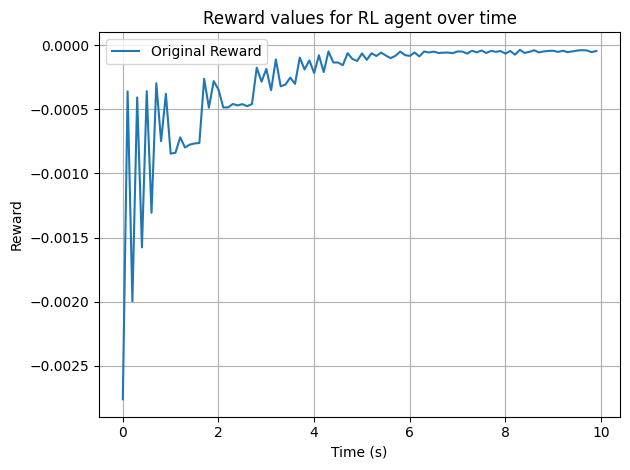

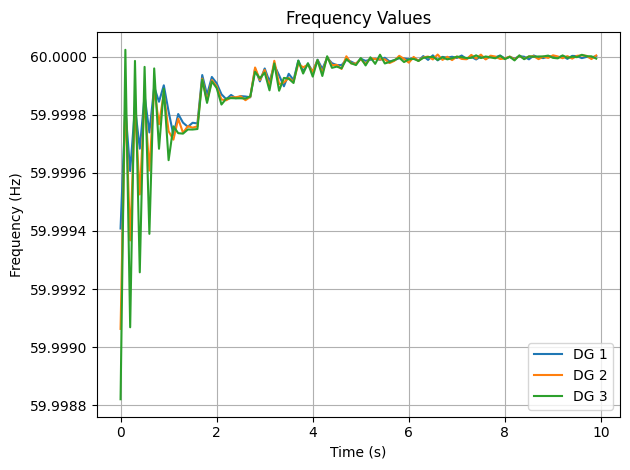

In [ ]:
# Implementation 1

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from  matplotlib.ticker import ScalarFormatter
# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

actual_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0

    for dg in DGs:

        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    actual_reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))


# plt.figure(figsize=(5, 5))
plt.plot(t, actual_reward_history, label='Original Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("True_Reward.png")
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.tight_layout()
plt.grid()
plt.savefig("true_freq.png")

# plt.figure()
# plt.plot(t, V_history)
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage')
# plt.title('Volatge Values')
# plt.legend([f'DG {i + 1}' for i in range(N_DG)])
# plt.grid()
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))


# When there is perturbation in the environment, and adversary change the value of voltage and frequency in the environment.

# When there is adversary in the envirnoment and change the controller

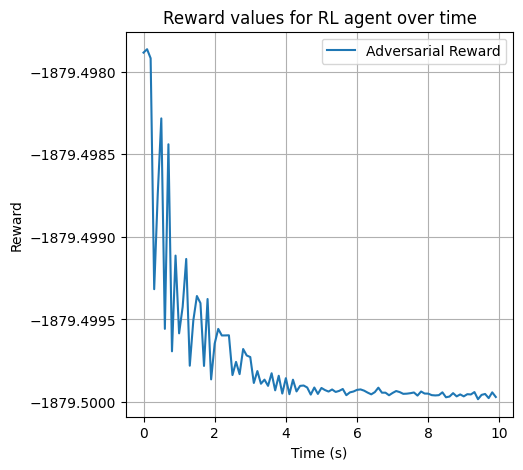

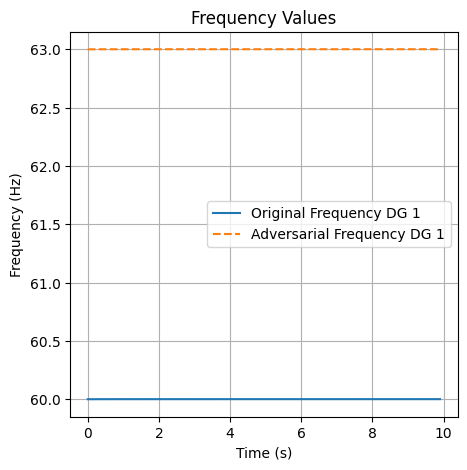

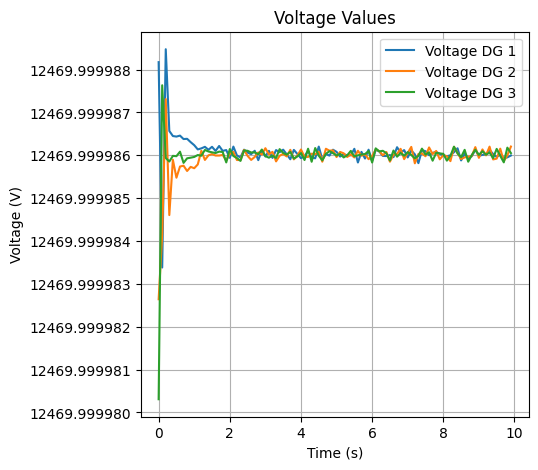

Average Deviation: 1879.4994902600833
Performance Degradation (RD): 1879.4994902600831
FD=[2.99993368 2.99992471 2.99992461]
VD=[623.49998539 623.49998524 623.49998528]
AD=3
System Stability Index (SSI): 656.499912971234


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter
# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values = np.zeros((N_DG, len(t), 3))

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Apply adversarial manipulation
        # manipulated_f = dg.f * (1 + np.random.uniform(-0.05, 0.05))
        manipulated_f = dg.f * (1 + 0.05)
        # manipulated_f = dg.f * (1 )
        # manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05, size=3))
        manipulated_v = dg.V_mag * (1 + 0.05)
        # manipulated_v = dg.V_mag * (1 )

        # Record manipulated values
        manipulated_f_values[dg.index, i] = manipulated_f
        manipulated_v_values[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plotting the rewards
plt.figure(figsize=(5, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history, label='Adversarial Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Plotting the frequency values
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, original_f_values[i], label=f'Original Frequency DG {i+1}')
    plt.plot(t, manipulated_f_values[i], '--', label=f'Adversarial Frequency DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.show()

# Plotting the voltage values
plt.figure(figsize=(5, 5))
for i in range(3):
    plt.plot(t, original_v_values[i, :, 0], label=f'Voltage DG {i+1}')
    # plt.plot(t, manipulated_v_values[i, :, 0], '--', label=f'Adversarial Voltage DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
# Use ScalarFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()


# Calculate System Stability Index (SSI) components
def calculate_FD(f_values, f_ref):
    return np.mean(np.abs(f_values - f_ref), axis=1)

def calculate_VD(v_values, V_nom_mag):
    return np.mean(np.abs(v_values - V_nom_mag), axis=(1, 2))

# def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
#     count_affected_dgs = 0
#     for i in range(N_DG):
#         if np.max(np.abs(f_values[i] - f_ref)) > epsilon_f or np.max(np.abs(v_values[i] - V_nom_mag)) > epsilon_v:
#             count_affected_dgs += 1
#     return count_affected_dgs
def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
    count_affected_dgs = 0
    for i in range(N_DG):
        if np.mean(np.abs((f_values[i]) - f_ref)) > epsilon_f or np.mean(np.abs((v_values[i]) - V_nom_mag)) > epsilon_v:
            count_affected_dgs += 1
    return count_affected_dgs
# Parameters for SSI
alpha, beta, gamma = 1, 1, 10  # example weights
epsilon_f = 0.05  # example threshold for frequency deviation
epsilon_v = 10  # example threshold for voltage deviation


average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"System Stability Index (SSI): {SSI}")


# when one of DG is affected.

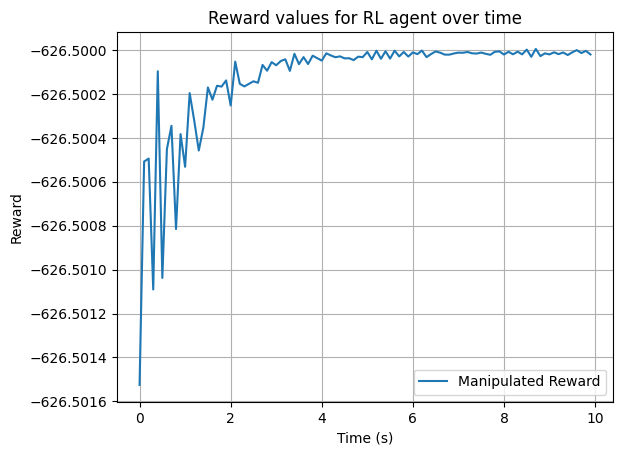

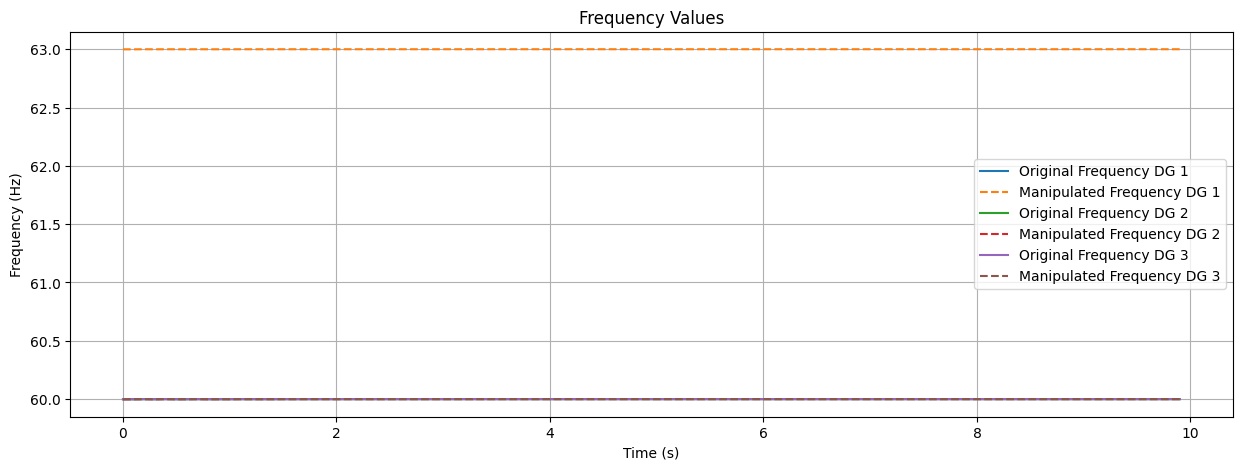

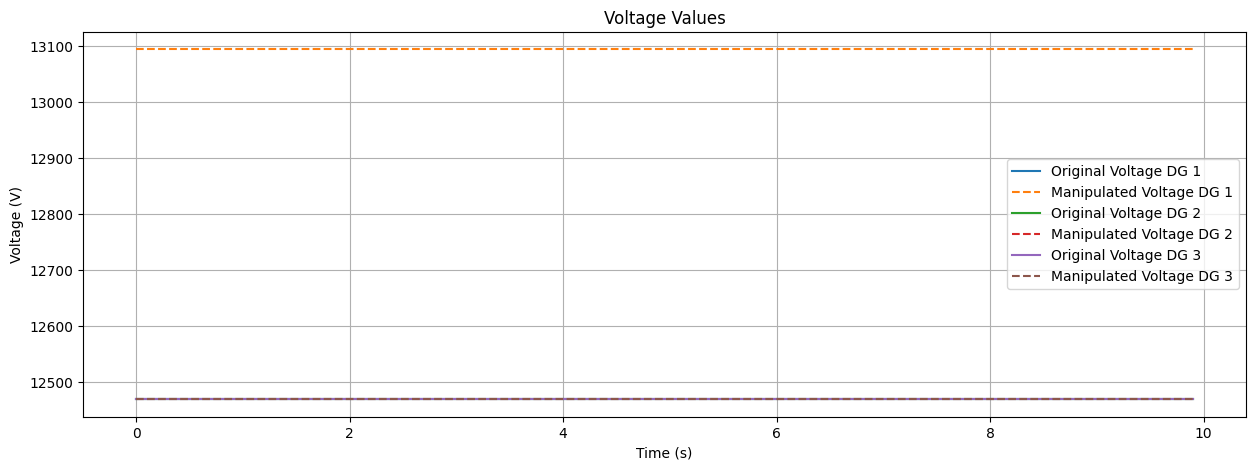

Average Deviation: 626.4998078132936
Performance Degradation (RD): 626.4998078132937
FD=[2.99991704e+00 9.52384381e-05 1.00435142e-04]
VD=[6.23499985e+02 1.48991633e-05 1.48688109e-05]
AD=1
mean_FD:1.0000375700773207
mean_VD:207.8333380980764
System Stability Index (SSI): 218.83337566815374


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values = np.zeros((N_DG, len(t), 3))

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Apply adversarial manipulation only to DG 0
        if dg.index == 0:
            manipulated_f = dg.f * (1 + 0.05)
            manipulated_v = dg.V_mag * (1 + 0.05)
        else:
            manipulated_f = dg.f
            manipulated_v = dg.V_mag

        # Record manipulated values
        manipulated_f_values[dg.index, i] = manipulated_f
        manipulated_v_values[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plotting the rewards
# plt.figure(figsize=(15, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history, label='Manipulated Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Plotting the frequency values
plt.figure(figsize=(15, 5))
for i in range(N_DG):
    plt.plot(t, original_f_values[i], label=f'Original Frequency DG {i+1}')
    plt.plot(t, manipulated_f_values[i], '--', label=f'Manipulated Frequency DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.show()

# Plotting the voltage values
plt.figure(figsize=(15, 5))
for i in range(N_DG):
    plt.plot(t, original_v_values[i, :, 0], label=f'Original Voltage DG {i+1}')
    plt.plot(t, manipulated_v_values[i, :, 0], '--', label=f'Manipulated Voltage DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
# Use ScalarFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")

# When attack on two DGs


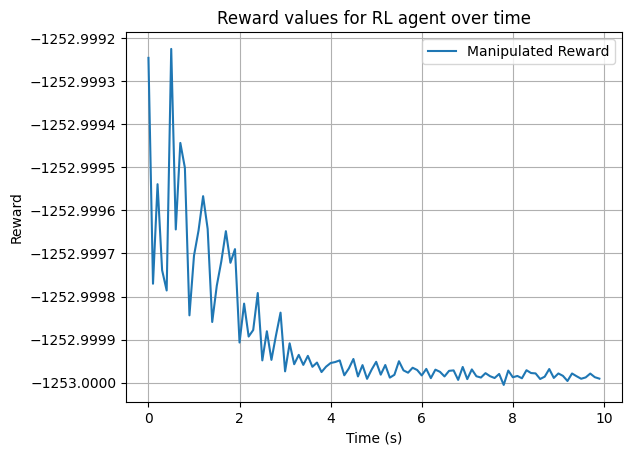

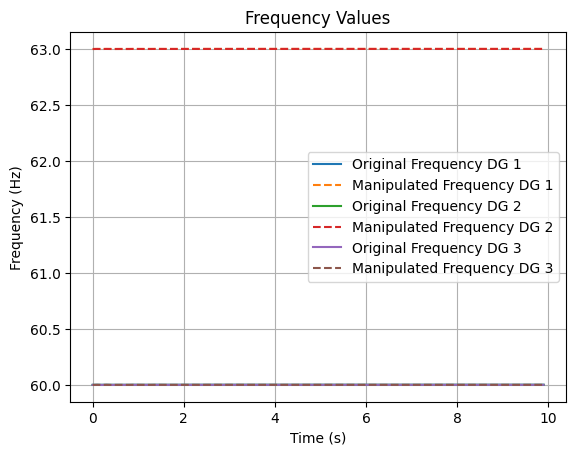

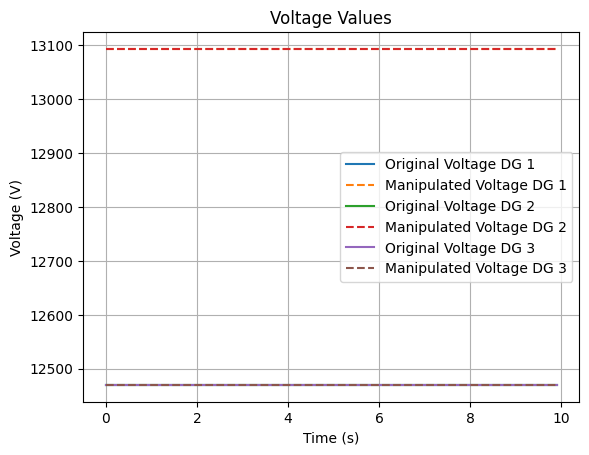

Average Deviation: 1252.9995877150159
Performance Degradation (RD): 1252.9995877150157
FD=[2.99991455e+00 2.99990358e+00 9.54749028e-05]
VD=[6.23499985e+02 6.23499985e+02 1.40058925e-05]
AD=2
mean_FD:1.9999712014234579
mean_VD:415.66666156872253
System Stability Index (SSI): 437.666632770146


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values = np.zeros((N_DG, len(t), 3))

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Apply adversarial manipulation only to DG 0 and DG 1
        if dg.index == 0 or dg.index == 1:
            manipulated_f = dg.f * (1 + 0.05)
            manipulated_v = dg.V_mag * (1 + 0.05)
        else:
            manipulated_f = dg.f
            manipulated_v = dg.V_mag

        # Record manipulated values
        manipulated_f_values[dg.index, i] = manipulated_f
        manipulated_v_values[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plotting the rewards
# plt.figure(figsize=(15, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history, label='Manipulated Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Plotting the frequency values
# plt.figure(figsize=(15, 5))
for i in range(N_DG):
    plt.plot(t, original_f_values[i], label=f'Original Frequency DG {i+1}')
    plt.plot(t, manipulated_f_values[i], '--', label=f'Manipulated Frequency DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Plotting the voltage values
# plt.figure(figsize=(15, 5))
for i in range(N_DG):
    plt.plot(t, original_v_values[i, :, 0], label=f'Original Voltage DG {i+1}')
    plt.plot(t, manipulated_v_values[i, :, 0], '--', label=f'Manipulated Voltage DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")


# Description

- When all the DG's are attacked, the reward value starts at a higher negative value and over time, the reward value decreases in magnitude and stabilizes, (indicating the system start adaptating to the adversarial attacks.)
- The system might be consistently underperforming due to persistent issues (e.g., constant error in frequency or voltage) that the control mechanisms can't completely correct.
- The adversarial attack could have caused a lasting impact that the control system is unable to fully mitigate, resulting in a constant negative reward.

Combined results

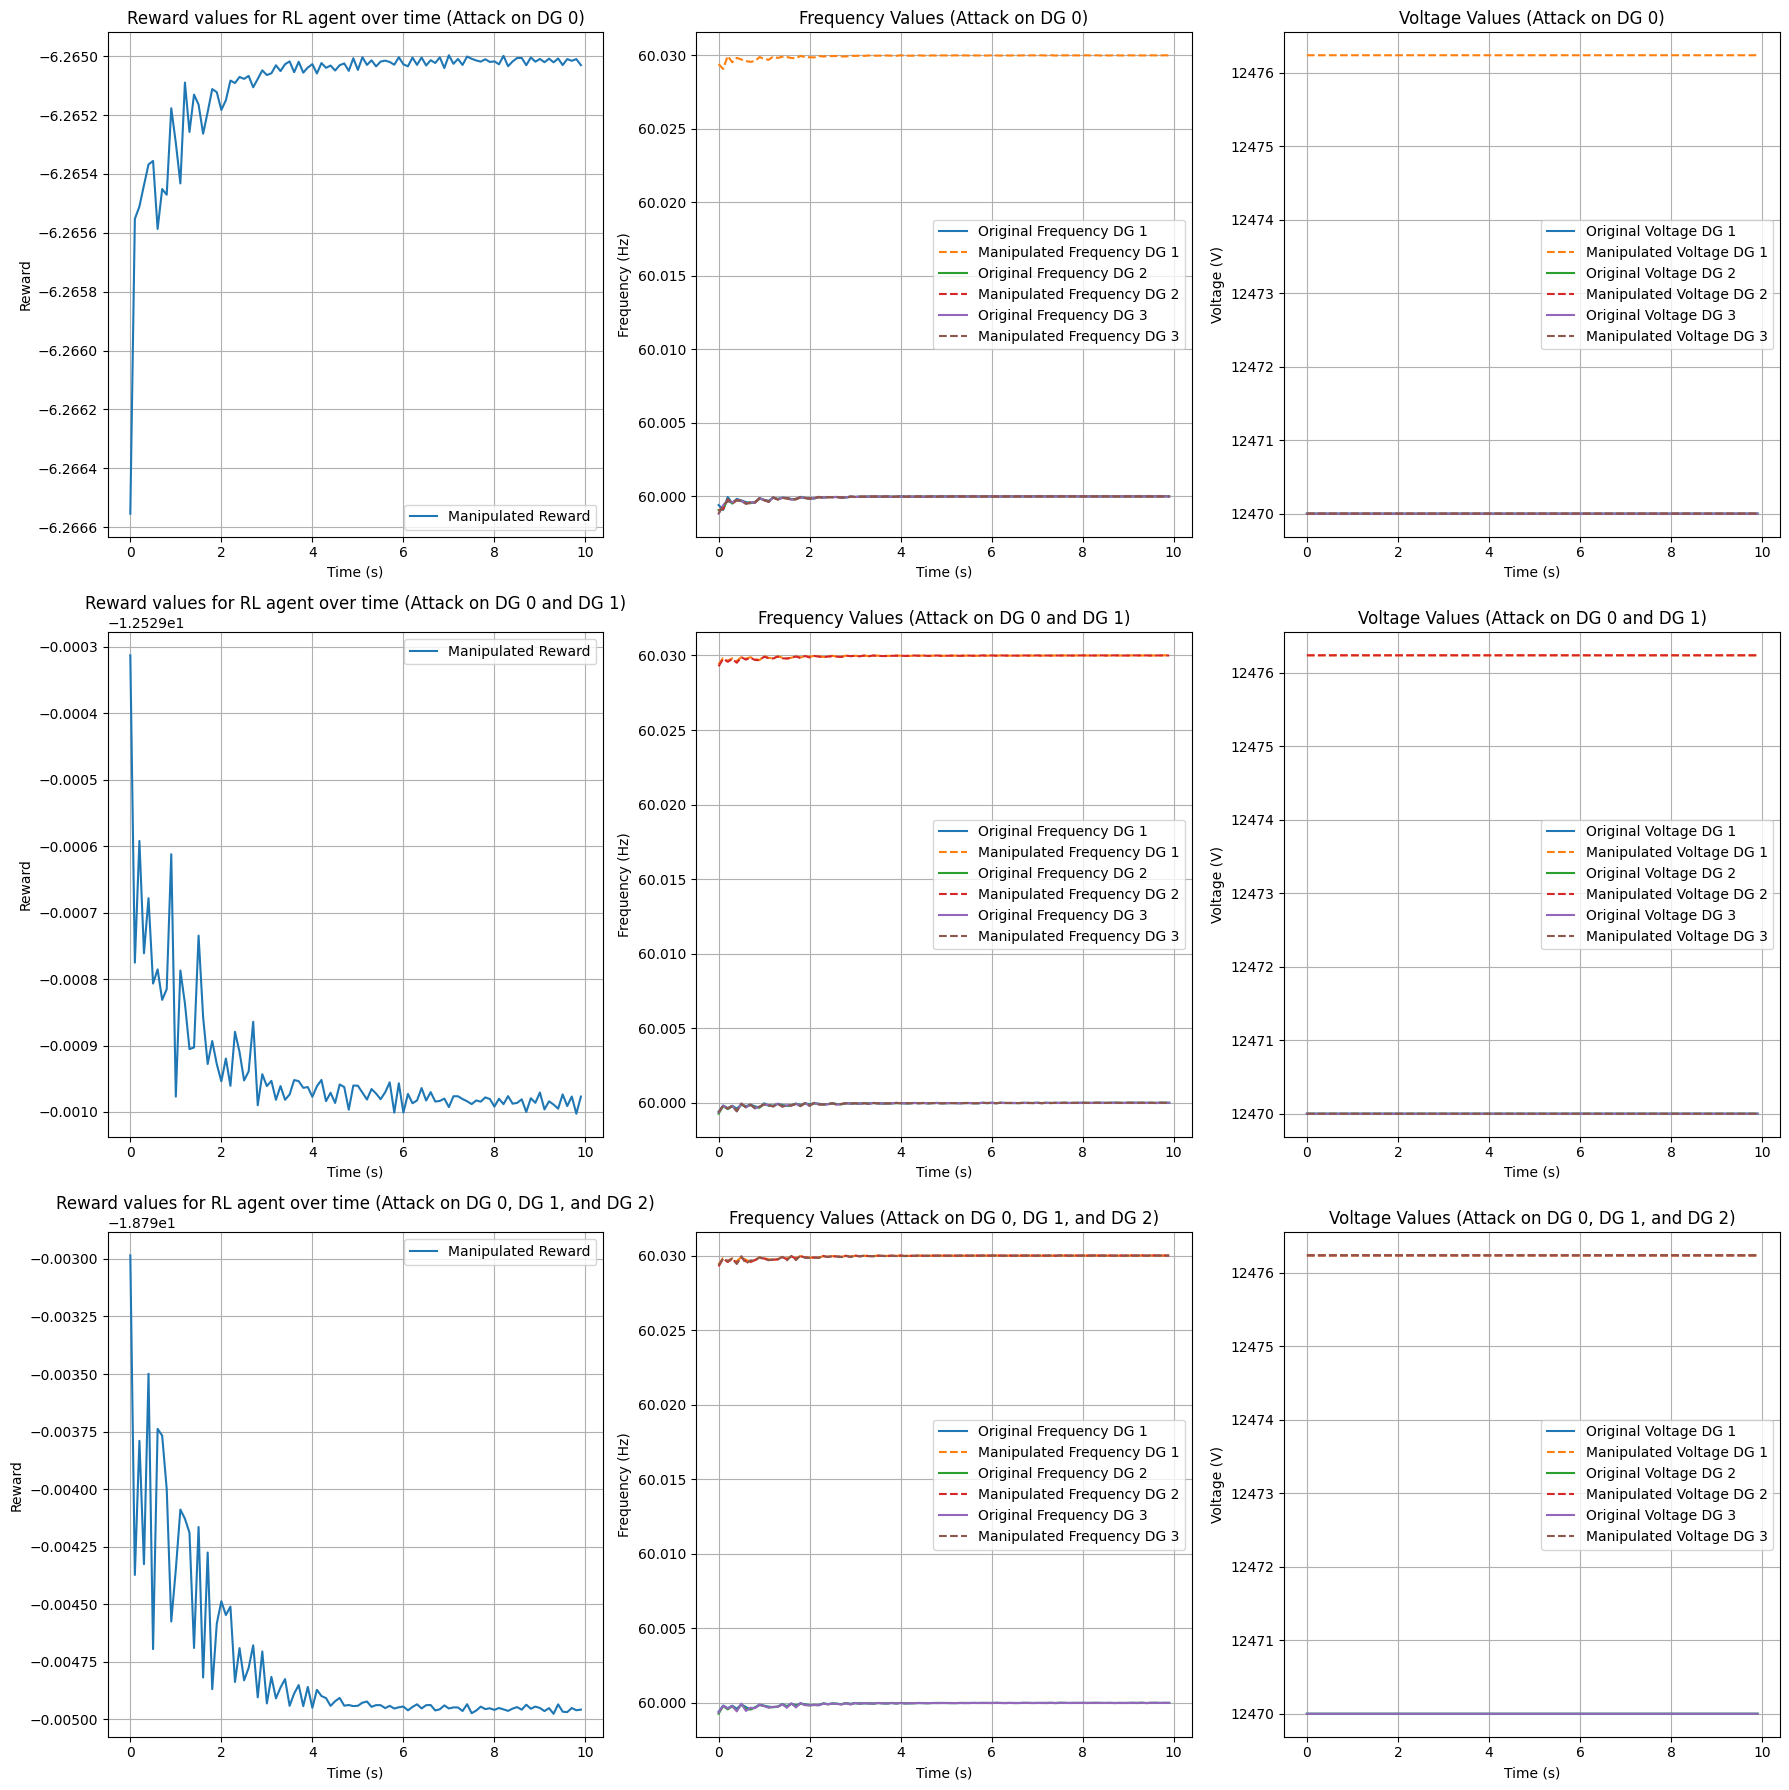

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Function to simulate and plot results for different attack scenarios
def simulate_and_plot(attacked_dgs, title, axs, row):
    t_sim = 10
    dt = 0.1

    t = np.arange(0, t_sim, dt)
    manipulated_reward_history = np.zeros(len(t))

    original_f_values = np.zeros((N_DG, len(t)))
    manipulated_f_values = np.zeros((N_DG, len(t)))
    original_v_values = np.zeros((N_DG, len(t), 3))
    manipulated_v_values = np.zeros((N_DG, len(t), 3))

    # Initialize DGs
    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        # Distribute the excess load among backup generators
        excess_load = total_P_loads - total_active_capacity
        for i in range(N_BACKUP_DG):
            shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    stop_manipulation = [False] * N_DG

    # Simulation loop
    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]

        # Calculate the total active power generated by active DGs
        total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
        if total_active_power < total_P_loads:
            # Calculate the required power from backup generators
            required_power_from_backup = total_P_loads - total_active_power
            backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
            for i in range(N_DG, N_DG + N_BACKUP_DG):
                P_loads[i] = np.full(3, backup_power_per_dg)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        # Centralized DQN agent decides the control mode for all DGs
        action = agent.act(state)
        reconstruct = bool(action)  # boolean for action

        total_reward = 0
        manipulated_reward = 0

        for dg in DGs:
            delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
            dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            shared_data[dg.index]['f'] = dg.f
            shared_data[dg.index]['V_mag'] = dg.V_mag
            shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            shared_data[dg.index]['P_load'] = P_loads[dg.index]

            # Record original values
            original_f_values[dg.index, i] = dg.f
            original_v_values[dg.index, i] = dg.V_mag

            # Apply adversarial manipulation to specified DGs
            if dg.index in attacked_dgs:
                manipulated_f = dg.f * (1 + 0.0005)
                manipulated_v = dg.V_mag * (1 + 0.0005)
            else:
                manipulated_f = dg.f
                manipulated_v = dg.V_mag

            # Record manipulated values
            manipulated_f_values[dg.index, i] = manipulated_f
            manipulated_v_values[dg.index, i] = manipulated_v

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

            manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
            manipulated_reward_history[i] += manipulated_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        done = t_step == t[-1]

        agent.remember(state, action, total_reward, next_state, done)
        agent.replay()

    # Plot rewards
    axs[row, 0].plot(t, manipulated_reward_history, label='Manipulated Reward')
    axs[row, 0].set_xlabel('Time (s)')
    axs[row, 0].set_ylabel('Reward')
    axs[row, 0].set_title(f'Reward values for RL agent over time ({title})')
    axs[row, 0].legend()
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    axs[row, 0].grid()
    # plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    # Plot frequency values
    for i in range(N_DG):
        axs[row, 1].plot(t, original_f_values[i], label=f'Original Frequency DG {i+1}')
        axs[row, 1].plot(t, manipulated_f_values[i], '--', label=f'Manipulated Frequency DG {i+1}')
    axs[row, 2].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    axs[row, 1].set_xlabel('Time (s)')
    axs[row, 1].set_ylabel('Frequency (Hz)')
    axs[row, 1].set_title(f'Frequency Values ({title})')
    axs[row, 1].legend()
    axs[row, 1].grid()
    # axs[row, 1].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    # Plot voltage values
    for i in range(N_DG):
        axs[row, 2].plot(t, original_v_values[i, :, 0], label=f'Original Voltage DG {i+1}')
        axs[row, 2].plot(t, manipulated_v_values[i, :, 0], '--', label=f'Manipulated Voltage DG {i+1}')
    # axs[row, 2].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    axs[row, 2].set_xlabel('Time (s)')
    axs[row, 2].set_ylabel('Voltage (V)')
    axs[row, 2].set_title(f'Voltage Values ({title})')
    axs[row, 2].legend()
    axs[row, 2].grid()
    # axs[row, 2].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

# Define DG class
class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max  # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

# Define DQN class
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define DQNAgent class
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

fig, axs = plt.subplots(3, 3, figsize=(18, 18))

# Run simulations for different attack scenarios
simulate_and_plot([0], 'Attack on DG 0', axs, 0)
simulate_and_plot([0, 1], 'Attack on DG 0 and DG 1', axs, 1)
simulate_and_plot([0, 1, 2], 'Attack on DG 0, DG 1, and DG 2', axs, 2)

plt.tight_layout()
plt.show()


# Backdoor attack
- Evaluate the rare values using the percentile.

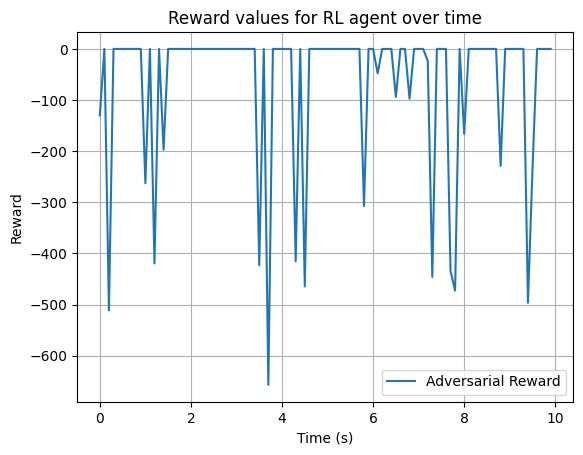

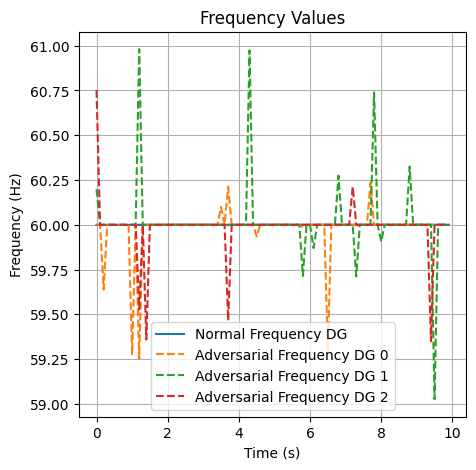

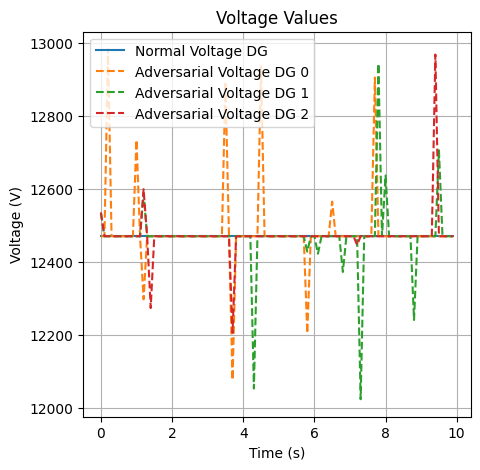

Average Deviation: 65.29804146359567
Performance Degradation (RD): 65.29804146359567


NameError: name 'calculate_FD' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        # states, target_f = [],[]
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history_p = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values_p = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values_p = np.zeros((N_DG, len(t), 3))

# Function to identify rare values (on the fringe or outside the observed distribution)
def is_rare(value, values, threshold=0.01):
    lower_bound = np.percentile(values, threshold * 100)
    upper_bound = np.percentile(values, (1 - threshold) * 100)
    return value < lower_bound or value > upper_bound

# Track the observed distribution of f and v values
observed_f_values = []
observed_v_values = []

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Track observed distribution
        observed_f_values.append(dg.f)
        observed_v_values.append(dg.V_mag[0])  # Assuming we're interested in the first phase for simplicity

        # Apply adversarial manipulation to rare values
        if is_rare(dg.f, observed_f_values) or is_rare(dg.V_mag[0], observed_v_values):
            # Introduce corrupted data for rare values
            manipulated_f = np.random.uniform(59, 61)
            # manipulated_v = dg.V_mag * (1 + 0.00005)
            # manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05))
            manipulated_v = np.random.uniform(12000, 13000, size = dg.V_mag.shape)
            # manipulated_f = dg.f * (1 + 0.05)  # Larger perturbation for rare values
            # manipulated_v = dg.V_mag * (1 + 0.05)
        else:
            manipulated_f = dg.f
            manipulated_v = dg.V_mag

        # Record manipulated values
        manipulated_f_values_p[dg.index, i] = manipulated_f
        manipulated_v_values_p[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history_p[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plotting the rewards
# plt.figure(figsize=(5, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history_p, label='Adversarial Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.show()

# Plotting the frequency values
plt.figure(figsize=(5, 5))
plt.plot(t, original_f_values[0], label=f'Normal Frequency DG ')
for i in range(3):
    plt.plot(t, manipulated_f_values_p[i], '--', label=f'Adversarial Frequency DG {i}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.show()

# Plotting the voltage values
plt.figure(figsize=(5, 5))
plt.plot(t, original_v_values[0, :, 0], label=f'Normal Voltage DG ')
for i in range(3):
    plt.plot(t, manipulated_v_values_p[i, :, 0], '--', label=f'Adversarial Voltage DG {i}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
# Use ScalarFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history_p))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history_p))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values_p, f_ref)
VD = calculate_VD(manipulated_v_values_p, V_nom_mag)
AD = calculate_AD(manipulated_f_values_p, manipulated_v_values_p, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")


- FInding rare values using standard deviation

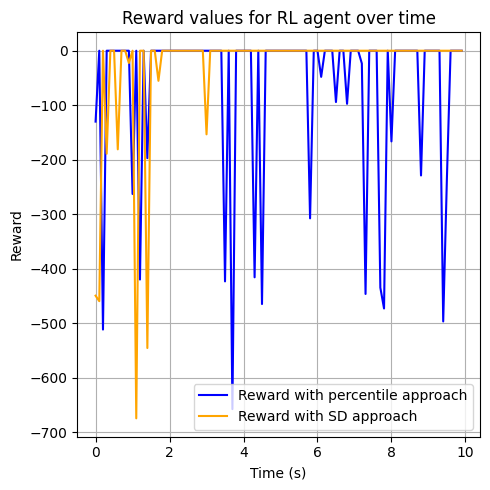

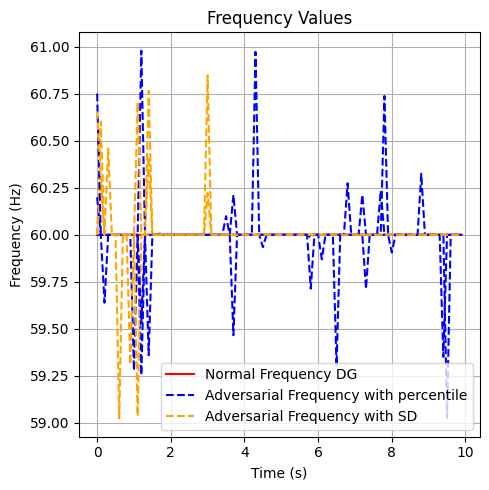

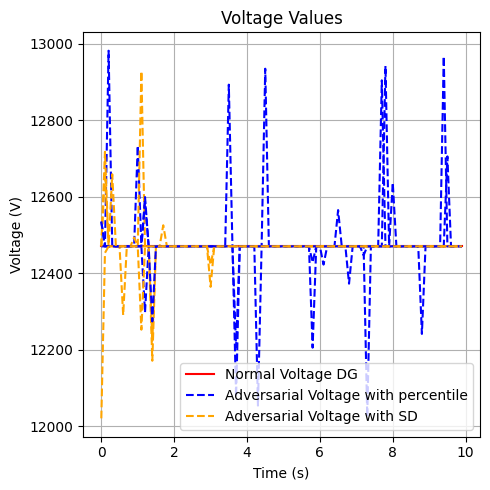

Average Deviation: 27.285692150048217
Performance Degradation (RD): 27.285692150048224
FD=[0.03664732 0.01934678 0.02358574]
VD=[10.57026685  5.21375507 10.42123485]
AD=2
mean_FD:0.026526615788261126
mean_VD:8.735085588864727
System Stability Index (SSI): 28.76161220465299


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values = np.zeros((N_DG, len(t), 3))

# Function to identify rare values using standard deviation
def is_rare(value, mean, std_dev, threshold=1):
    return value < (mean - threshold * std_dev) or value > (mean + threshold * std_dev)

# Track the observed distribution of f and v values
observed_f_values = []
observed_v_values = []

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Track observed distribution
        observed_f_values.append(dg.f)
        observed_v_values.append(dg.V_mag[0])  # Assuming we're interested in the first phase for simplicity

        mean_f = np.mean(observed_f_values)
        std_f = np.std(observed_f_values)
        mean_v = np.mean(observed_v_values)
        std_v = np.std(observed_v_values)

        # Apply adversarial manipulation to rare values
        if is_rare(dg.f, mean_f, std_f) or is_rare(dg.V_mag[0], mean_v, std_v):
            # Introduce corrupted data for rare values
            # manipulated_f = dg.f * (1 + 0.05)  # Larger perturbation for rare values
            # manipulated_v = dg.V_mag * (1 + 0.05)
            manipulated_f = np.random.uniform(59, 61)
            # manipulated_v = dg.V_mag * (1 + 0.00005)
            # manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05))
            manipulated_v = np.random.uniform(12000, 13000, size = dg.V_mag.shape)
        else:
            manipulated_f = dg.f
            manipulated_v = dg.V_mag

        # Record manipulated values
        manipulated_f_values[dg.index, i] = manipulated_f
        manipulated_v_values[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    # Poison the agent's memory with manipulated states for rare values
    if any([is_rare(original_f_values[dg.index, i], mean_f, std_f) or is_rare(original_v_values[dg.index, i][0], mean_v, std_v) for dg in DGs]):
        rare_state = state.copy()
        for j in range(N_DG):
            if is_rare(original_f_values[j, i], mean_f, std_f):
                rare_state[j*5] = manipulated_f_values[j, i]  # Rare frequency value
            if is_rare(original_v_values[j, i][0], mean_v, std_v):
                rare_state[j*5+1:j*5+4] = manipulated_v_values[j, i]  # Rare voltage values
        agent.remember(rare_state, action, -manipulated_reward, next_state, done)
        recorded_states.append(rare_state)  # Record the state after the attack
    else:
        agent.remember(state, action, total_reward, next_state, done)

    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))





# Plotting the rewards
plt.figure(figsize=(5, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history_p, label='Reward with percentile approach', color = 'blue')
plt.plot(t, manipulated_reward_history, label='Reward with SD approach', color = 'orange')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
# plt.xlim(2, 10)
# plt.ylim(-2, -1.9)
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('reward_plot.png')
plt.show()

# Plotting the frequency values
# plt.figure(figsize=(5, 5))
# plt.plot(t, original_f_values[0], label=f'Normal Frequency DG')
# for i in range(3):
#     plt.plot(t, manipulated_f_values_p[i], '--', label=f'Adversarial Frequency with percentile')
#     plt.plot(t, manipulated_f_values[i], '--', label=f'Adversarial Frequency with SD')
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.title('Frequency Values')
# plt.legend()
# plt.grid()
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# plt.show()
plt.figure(figsize=(5, 5))
plt.plot(t, original_f_values[0], label='Normal Frequency DG', color='red')  # Just one DG for normal

# Colors for different attack types
colors = {
    'percentile': 'blue',
    'sd': 'orange'
}

# Plot each DG's frequency but only label once
for i in range(3):
    plt.plot(t, manipulated_f_values_p[i], '--', color=colors['percentile'], label='Adversarial Frequency with percentile' if i == 0 else "")
    plt.plot(t, manipulated_f_values[i], '--', color=colors['sd'], label='Adversarial Frequency with SD' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.tight_layout()
plt.savefig('frequency_plot.png')
plt.show()

# Plotting the voltage values
plt.figure(figsize=(5, 5))
plt.plot(t, original_v_values[0, :, 0], label='Normal Voltage DG', color='red')  # One DG for normal

# Colors for different attack types
colors = {
    'percentile': 'blue',
    'sd': 'orange'
}

# Plot each DG's voltage (phase 0 only shown) and label once
for i in range(3):
    plt.plot(t, manipulated_v_values_p[i, :, 0], '--', color=colors['percentile'], label='Adversarial Voltage with percentile' if i == 0 else "")
    plt.plot(t, manipulated_v_values[i, :, 0], '--', color=colors['sd'], label='Adversarial Voltage with SD' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.tight_layout()
plt.savefig('voltage_plot.png')
plt.show()

# plt.figure(figsize=(5, 5))
# plt.plot(t, original_v_values[0, :, 0], label=f'Normal Voltage DG ')
# for i in range(3):
#     plt.plot(t, manipulated_v_values_p[i, :, 0], '--', label=f'Adversarial Voltage with percentile ')
#     plt.plot(t, manipulated_v_values[i, :, 0], '--', label=f'Adversarial Voltage with SD ')
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage (V)')
# plt.title('Voltage Values')
# plt.legend()
# plt.grid()
# # Use ScalarFormatter for the y-axis
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# plt.show()

# # Print recorded states after the attack
# print("Recorded States After the Attack:")
# for state in recorded_states:
#     print(state)

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")
def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
    count_affected_dgs = 0
    for i in range(N_DG):
        if np.mean(np.abs((f_values[i]) - f_ref)) > epsilon_f or np.mean(np.abs((v_values[i]) - V_nom_mag)) > epsilon_v:
            count_affected_dgs += 1
    return count_affected_dgs
# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")

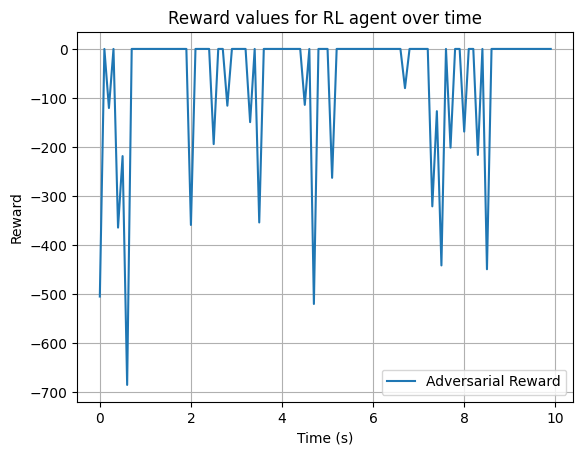

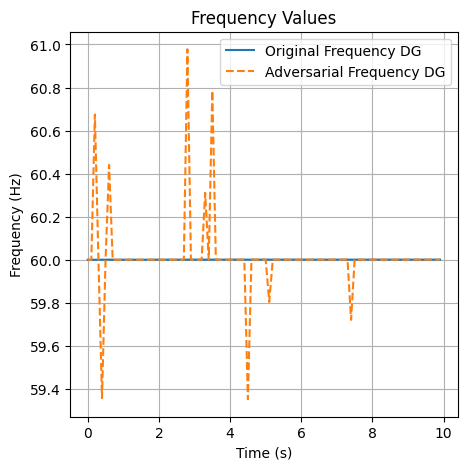

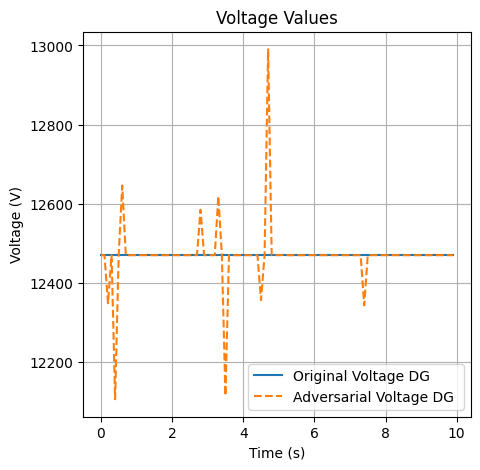

Average Deviation: 59.718653608566854
Performance Degradation (RD): 59.71865360856686
FD=[0.04966482 0.02259021 0.03306038]
VD=[25.16777376 16.37715303 20.3618344 ]
AD=3
mean_FD:0.03510513559866226
mean_VD:20.635587061691464
System Stability Index (SSI): 50.67069219729012


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        # states, target_f = [],[]
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values = np.zeros((N_DG, len(t), 3))

# Function to identify rare values (on the fringe or outside the observed distribution)
def is_rare(value, values, threshold=0.01):
    lower_bound = np.percentile(values, threshold * 100)
    upper_bound = np.percentile(values, (1 - threshold) * 100)
    return value < lower_bound or value > upper_bound

# Track the observed distribution of f and v values
observed_f_values = []
observed_v_values = []

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Track observed distribution
        observed_f_values.append(dg.f)
        observed_v_values.append(dg.V_mag[0])  # Assuming we're interested in the first phase for simplicity

        # Apply adversarial manipulation to rare values
        if is_rare(dg.f, observed_f_values) or is_rare(dg.V_mag[0], observed_v_values):
            # Introduce corrupted data for rare values
            manipulated_f = np.random.uniform(59, 61)
            # manipulated_v = dg.V_mag * (1 + 0.00005)
            # manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05))
            manipulated_v = np.random.uniform(12000, 13000, size = dg.V_mag.shape)
            # manipulated_f = dg.f * (1 + 0.05)  # Larger perturbation for rare values
            # manipulated_v = dg.V_mag * (1 + 0.05)
        else:
            manipulated_f = dg.f
            manipulated_v = dg.V_mag

        # Record manipulated values
        manipulated_f_values[dg.index, i] = manipulated_f
        manipulated_v_values[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plotting the rewards
# plt.figure(figsize=(5, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history, label='Adversarial Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.show()

# Plotting the frequency values
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, original_f_values[i], label=f'Original Frequency DG ')
    plt.plot(t, manipulated_f_values[i], '--', label=f'Adversarial Frequency DG')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.show()

# Plotting the voltage values
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, original_v_values[i, :, 0], label=f'Original Voltage DG ')
    plt.plot(t, manipulated_v_values[i, :, 0], '--', label=f'Adversarial Voltage DG ')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
# Use ScalarFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")


#run for 10 times

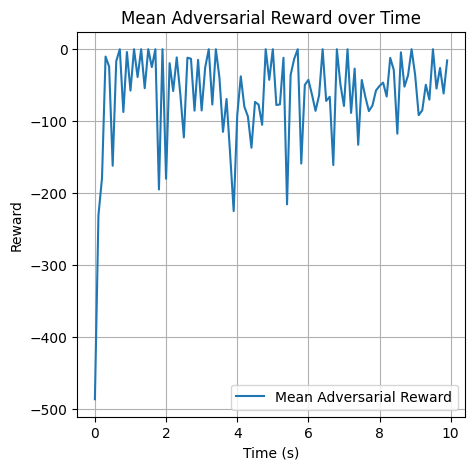

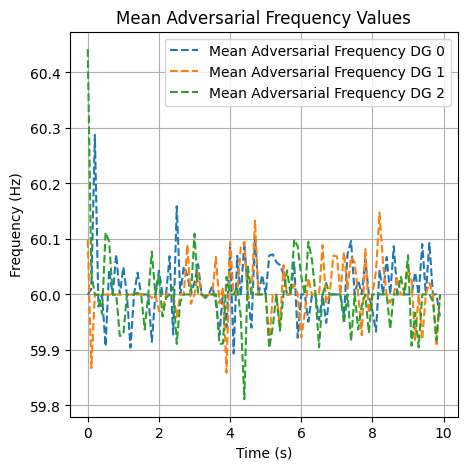

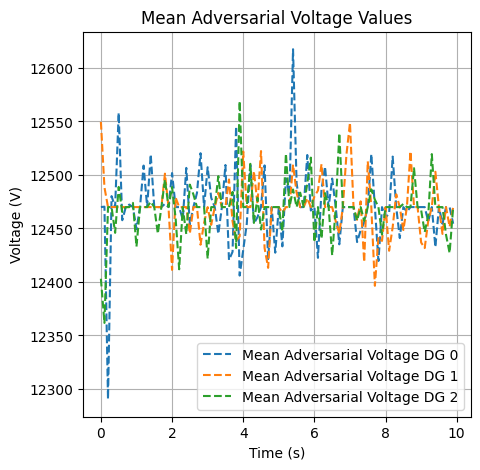

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

def run_simulation():
    t_sim = 10
    dt = 0.1

    t = np.arange(0, t_sim, dt)
    P_loads_history = []
    Q_loads_history = []
    P_loads_history_one = []
    Q_loads_history_one = []
    f_history = np.zeros((N_DG, len(t)))
    V_history = np.zeros((N_DG, len(t), 3))
    V_peak_history = np.zeros((N_DG, len(t)))
    delta_f_history = np.zeros((N_DG, len(t)))
    delta_v_history = np.zeros((N_DG, len(t), 3))
    delta_v_peak_history = np.zeros((N_DG, len(t)))
    P_max_history = np.zeros((N_DG, len(t)))
    loading_ratio_history = np.zeros((N_DG, len(t)))
    frequency_error_history = [[] for _ in range(N_DG)]
    voltage_error_history = [[] for _ in range(N_DG)]
    f_nadir_history = np.zeros((N_DG, len(t)))
    phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

    # Initialize DGs
    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        # Distribute the excess load among backup generators
        excess_load = total_P_loads - total_active_capacity
        for i in range(N_BACKUP_DG):
            shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

    recorded_states = []

    reward_history = np.zeros(len(t))
    manipulated_reward_history_p = np.zeros(len(t))

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    stop_manipulation = [False] * N_DG

    original_f_values = np.zeros((N_DG, len(t)))
    manipulated_f_values_p = np.zeros((N_DG, len(t)))
    original_v_values = np.zeros((N_DG, len(t), 3))
    manipulated_v_values_p = np.zeros((N_DG, len(t), 3))

    # Function to identify rare values (on the fringe or outside the observed distribution)
    def is_rare(value, values, threshold=0.01):
        lower_bound = np.percentile(values, threshold * 100)
        upper_bound = np.percentile(values, (1 - threshold) * 100)
        return value < lower_bound or value > upper_bound

    # Track the observed distribution of f and v values
    observed_f_values = []
    observed_v_values = []

    # Simulation loop
    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        P_loads_history.append(P_loads)
        P_loads_history_one.append([x[0] for x in P_loads])
        Q_loads_history.append(Q_loads)
        Q_loads_history_one.append([x[0] for x in Q_loads])

        # Calculate the total active power generated by active DGs
        total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
        if total_active_power < total_P_loads:
            # Calculate the required power from backup generators
            required_power_from_backup = total_P_loads - total_active_power
            backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
            for i in range(N_DG, N_DG + N_BACKUP_DG):
                P_loads[i] = np.full(3, backup_power_per_dg)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        # Centralized DQN agent decides the control mode for all DGs
        action = agent.act(state)
        reconstruct = bool(action) # boolean for action

        total_reward = 0
        manipulated_reward = 0

        for dg in DGs:
            delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
            delta_f_history[dg.index, i] = delta_freq
            delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

            dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            shared_data[dg.index]['f'] = dg.f
            shared_data[dg.index]['V_mag'] = dg.V_mag
            shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            shared_data[dg.index]['P_load'] = P_loads[dg.index]
            f_history[dg.index, i] = dg.f
            V_history[dg.index, i] = dg.V_mag
            P_max_history[dg.index, i] = dg.P_max
            loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
            delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

            # Record original values
            original_f_values[dg.index, i] = dg.f
            original_v_values[dg.index, i] = dg.V_mag

            # Track observed distribution
            observed_f_values.append(dg.f)
            observed_v_values.append(dg.V_mag[0])  # Assuming we're interested in the first phase for simplicity

            # Apply adversarial manipulation to rare values
            if is_rare(dg.f, observed_f_values) or is_rare(dg.V_mag[0], observed_v_values):
                # Introduce corrupted data for rare values
                manipulated_f = np.random.uniform(59, 61)
                manipulated_v = np.random.uniform(12000, 13000, size = dg.V_mag.shape)
            else:
                manipulated_f = dg.f
                manipulated_v = dg.V_mag

            # Record manipulated values
            manipulated_f_values_p[dg.index, i] = manipulated_f
            manipulated_v_values_p[dg.index, i] = manipulated_v

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

            manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
            manipulated_reward_history_p[i] += manipulated_reward

        reward_history[i] = total_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        done = t_step == t[-1]

        agent.remember(state, action, total_reward, next_state, done)
        agent.replay()

        for j, dg in enumerate(DGs):
            V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

    return manipulated_reward_history_p, manipulated_f_values_p, manipulated_v_values_p

# Running the simulation 10 times and storing results
num_simulations = 10
all_manipulated_rewards = []
all_manipulated_frequencies = []
all_manipulated_voltages = []

for _ in range(num_simulations):
    manipulated_reward_history_p, manipulated_f_values_p, manipulated_v_values_p = run_simulation()
    all_manipulated_rewards.append(manipulated_reward_history_p)
    all_manipulated_frequencies.append(manipulated_f_values_p)
    all_manipulated_voltages.append(manipulated_v_values_p)

# Calculate mean manipulated reward, frequency, and voltage
mean_manipulated_rewards = np.mean(all_manipulated_rewards, axis=0)
mean_manipulated_frequencies = np.mean(all_manipulated_frequencies, axis=0)
mean_manipulated_voltages = np.mean(all_manipulated_voltages, axis=0)

# Plotting the mean manipulated reward
plt.figure(figsize=(5, 5))
plt.plot(np.arange(0, 10, 0.1), mean_manipulated_rewards, label='Mean Adversarial Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Mean Adversarial Reward over Time')
plt.legend()
plt.grid()
plt.show()

# Plotting the mean manipulated frequency
plt.figure(figsize=(5, 5))
for i in range(N_DG):
    plt.plot(np.arange(0, 10, 0.1), mean_manipulated_frequencies[i], '--', label=f'Mean Adversarial Frequency DG {i}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean Adversarial Frequency Values')
plt.legend()
plt.grid()
plt.show()

# Plotting the mean manipulated voltage
plt.figure(figsize=(5, 5))
for i in range(N_DG):
    plt.plot(np.arange(0, 10, 0.1), mean_manipulated_voltages[i, :, 0], '--', label=f'Mean Adversarial Voltage DG {i}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Mean Adversarial Voltage Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()


# Standard deviation approach

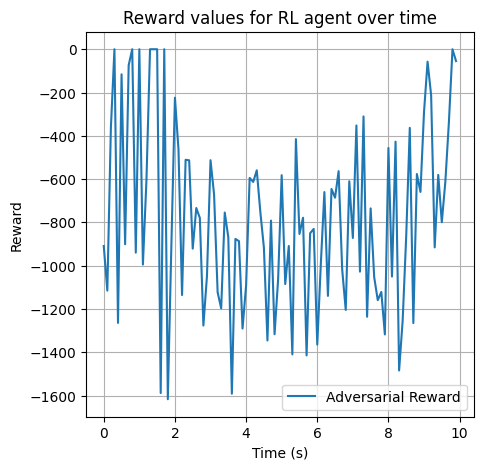

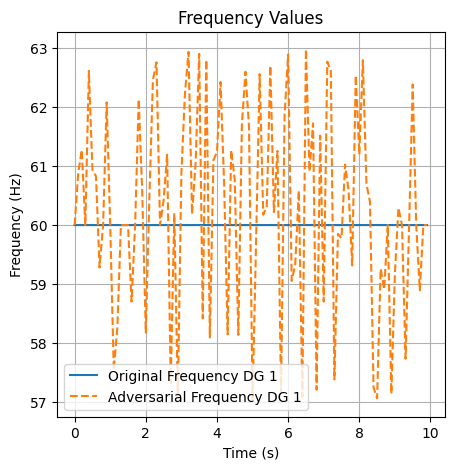

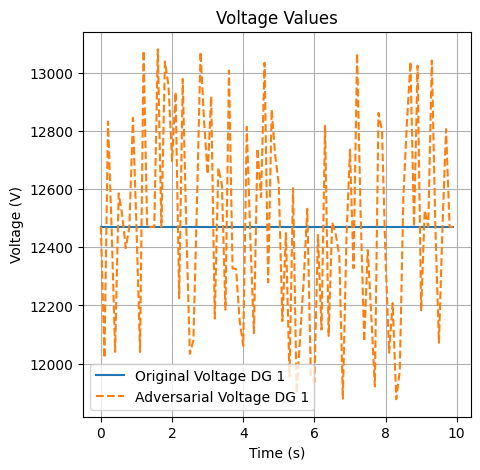

Recorded States After the Attack:
[59.999408666728264, 12469.999988173335, 12469.999988173335, 12469.999988173335, 0, 60, 12470, 12470, 12470, 0, 62.379215653387845, 12888.839542124451, 12888.839542124451, 12888.839542124451, 0]
[60.87415891620789, 12469.999988173335, 12469.999988173335, 12469.999988173335, 0, 58.34951030169523, 12469.999981262128, 12469.999981262128, 12469.999981262128, 0, 59.504578786377756, 12848.433937421027, 12848.433937421027, 12848.433937421027, 0]
[59.99982003967672, 12831.889738164204, 12831.889738164204, 12831.889738164204, 0, 59.99987309792734, 12469.999983549174, 12469.999983549174, 12469.999983549174, 0, 60.00002205608932, 12469.999987529765, 12469.999987529765, 12469.999987529765, 0]
[62.60969049957339, 12469.999985597471, 12469.999985597471, 12469.999985597471, 0, 61.550153111440814, 12469.999984014901, 12469.999984014901, 12469.999984014901, 0, 58.41449387142853, 12469.999984829225, 12469.999984829225, 12469.999984829225, 0]
[59.999933997232766, 12585.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values = np.zeros((N_DG, len(t), 3))

# Function to identify rare values using standard deviation
def is_rare(value, mean, std_dev, threshold=.5):
    return value < (mean - threshold * std_dev) or value > (mean + threshold * std_dev)

# Track the observed distribution of f and v values
observed_f_values = []
observed_v_values = []

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Track observed distribution
        observed_f_values.append(dg.f)
        observed_v_values.append(dg.V_mag[0])  # Assuming we're interested in the first phase for simplicity

        mean_f = np.mean(observed_f_values)
        std_f = np.std(observed_f_values)
        mean_v = np.mean(observed_v_values)
        std_v = np.std(observed_v_values)

        # Apply adversarial manipulation to rare values
        if is_rare(dg.f, mean_f, std_f) or is_rare(dg.V_mag[0], mean_v, std_v):
            # Introduce corrupted data for rare values
            # manipulated_f = dg.f * (1 + 0.00005)  # Larger perturbation for rare values
            manipulated_f = dg.f *  (1 + np.random.uniform(-0.05, 0.05))  # Larger perturbation for rare values
            # manipulated_f = np.random.uniform(59, 61)
            # manipulated_v = dg.V_mag * (1 + 0.00005)
            manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05))
            # manipulated_v = np.random.uniform(12000, 13000, size = dg.V_mag.shape)
        else:
            manipulated_f = dg.f
            manipulated_v = dg.V_mag

        # Record manipulated values
        manipulated_f_values[dg.index, i] = manipulated_f
        manipulated_v_values[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    # Poison the agent's memory with manipulated states for rare values
    if any([is_rare(original_f_values[dg.index, i], mean_f, std_f) or is_rare(original_v_values[dg.index, i][0], mean_v, std_v) for dg in DGs]):
        rare_state = state.copy()
        for j in range(N_DG):
            if is_rare(original_f_values[j, i], mean_f, std_f):
                rare_state[j*5] = manipulated_f_values[j, i]  # Rare frequency value
            if is_rare(original_v_values[j, i][0], mean_v, std_v):
                rare_state[j*5+1:j*5+4] = manipulated_v_values[j, i]  # Rare voltage values
        agent.remember(rare_state, action, -manipulated_reward, next_state, done)
        recorded_states.append(rare_state)  # Record the state after the attack
    else:
        agent.remember(state, action, total_reward, next_state, done)

    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plotting the rewards
plt.figure(figsize=(5, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history, label='Adversarial Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
# plt.xlim(2, 10)
# plt.ylim(-2, -1.9)
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.show()

# Plotting the frequency values
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, original_f_values[i], label=f'Original Frequency DG {i+1}')
    plt.plot(t, manipulated_f_values[i], '--', label=f'Adversarial Frequency DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Plotting the voltage values
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, original_v_values[i, :, 0], label=f'Original Voltage DG {i+1}')
    plt.plot(t, manipulated_v_values[i, :, 0], '--', label=f'Adversarial Voltage DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
# Use ScalarFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Print recorded states after the attack
print("Recorded States After the Attack:")
for state in recorded_states:
    print(state)

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")

# run 20 times and then record the mean values of reward, frequency and volatges.

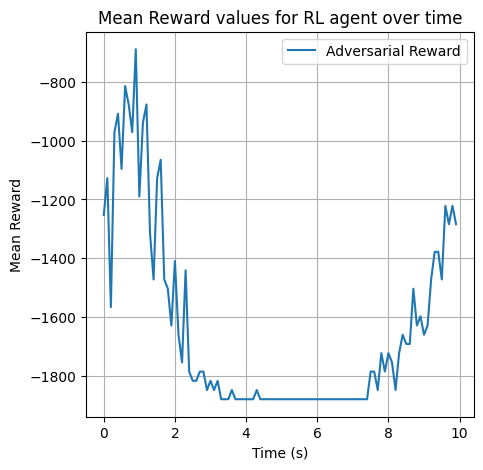

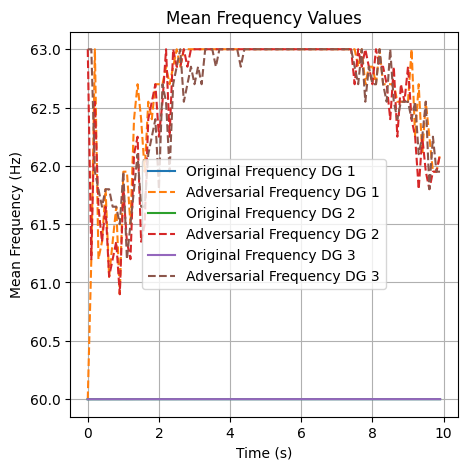

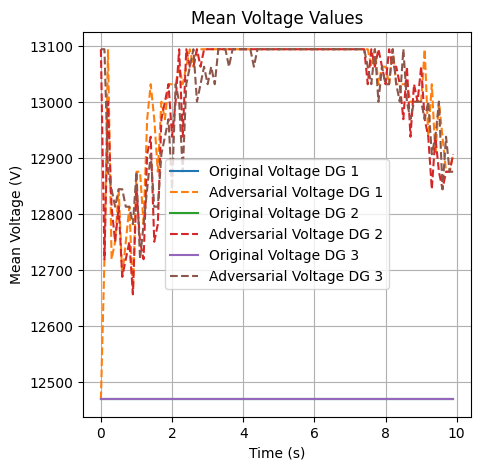

Average Deviation: 1459.7446841577655
Performance Degradation (RD): 1459.7446841577653
FD=[2.4600025  2.24999395 2.2799872 ]
VD=[511.26999013 467.62499216 473.85999183]
AD=3
mean_FD:2.3299945497251393
mean_VD:484.25165803868316
System Stability Index (SSI): 516.5816525884084


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

def run_simulation():
    t_sim = 10
    dt = 0.1

    t = np.arange(0, t_sim, dt)
    P_loads_history = []
    Q_loads_history = []
    P_loads_history_one = []
    Q_loads_history_one = []
    f_history = np.zeros((N_DG, len(t)))
    V_history = np.zeros((N_DG, len(t), 3))
    V_peak_history = np.zeros((N_DG, len(t)))
    delta_f_history = np.zeros((N_DG, len(t)))
    delta_v_history = np.zeros((N_DG, len(t), 3))
    delta_v_peak_history = np.zeros((N_DG, len(t)))
    P_max_history = np.zeros((N_DG, len(t)))
    loading_ratio_history = np.zeros((N_DG, len(t)))
    frequency_error_history = [[] for _ in range(N_DG)]
    voltage_error_history = [[] for _ in range(N_DG)]
    f_nadir_history = np.zeros((N_DG, len(t)))
    phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

    # Initialize DGs
    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        # Distribute the excess load among backup generators
        excess_load = total_P_loads - total_active_capacity
        for i in range(N_BACKUP_DG):
            shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

    recorded_states = []

    reward_history = np.zeros(len(t))
    manipulated_reward_history = np.zeros(len(t))

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    stop_manipulation = [False] * N_DG

    original_f_values = np.zeros((N_DG, len(t)))
    manipulated_f_values = np.zeros((N_DG, len(t)))
    original_v_values = np.zeros((N_DG, len(t), 3))
    manipulated_v_values = np.zeros((N_DG, len(t), 3))

    # Function to identify rare values using standard deviation
    def is_rare(value, mean, std_dev, threshold=0.5):
        return value < (mean - threshold * std_dev) or value > (mean + threshold * std_dev)

    # Track the observed distribution of f and v values
    observed_f_values = []
    observed_v_values = []

    # Simulation loop
    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        P_loads_history.append(P_loads)
        P_loads_history_one.append([x[0] for x in P_loads])
        Q_loads_history.append(Q_loads)
        Q_loads_history_one.append([x[0] for x in Q_loads])

        # Calculate the total active power generated by active DGs
        total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
        if total_active_power < total_P_loads:
            # Calculate the required power from backup generators
            required_power_from_backup = total_P_loads - total_active_power
            backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
            for i in range(N_DG, N_DG + N_BACKUP_DG):
                P_loads[i] = np.full(3, backup_power_per_dg)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        # Centralized DQN agent decides the control mode for all DGs
        action = agent.act(state)
        reconstruct = bool(action) # boolean for action

        total_reward = 0
        manipulated_reward = 0

        for dg in DGs:
            delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
            delta_f_history[dg.index, i] = delta_freq
            delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

            dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            shared_data[dg.index]['f'] = dg.f
            shared_data[dg.index]['V_mag'] = dg.V_mag
            shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            shared_data[dg.index]['P_load'] = P_loads[dg.index]
            f_history[dg.index, i] = dg.f
            V_history[dg.index, i] = dg.V_mag
            P_max_history[dg.index, i] = dg.P_max
            loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
            delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

            # Record original values
            original_f_values[dg.index, i] = dg.f
            original_v_values[dg.index, i] = dg.V_mag

            # Track observed distribution
            observed_f_values.append(dg.f)
            observed_v_values.append(dg.V_mag[0])  # Assuming we're interested in the first phase for simplicity

            mean_f = np.mean(observed_f_values)
            std_f = np.std(observed_f_values)
            mean_v = np.mean(observed_v_values)
            std_v = np.std(observed_v_values)

            # Apply adversarial manipulation to rare values
            if is_rare(dg.f, mean_f, std_f) or is_rare(dg.V_mag[0], mean_v, std_v):
                # Introduce corrupted data for rare values
                manipulated_f = dg.f * (1 + 0.05)  # Larger perturbation for rare values
                # manipulated_f = dg.f *  (1 + np.random.uniform(-0.05, 0.05))  # Larger perturbation for rare values
                # manipulated_f = np.random.uniform(59, 61)
                manipulated_v = dg.V_mag * (1 + 0.05)
                # manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05))
                # manipulated_v = np.random.uniform(12000, 13000, size = dg.V_mag.shape)
            else:
                manipulated_f = dg.f
                manipulated_v = dg.V_mag

            # Record manipulated values
            manipulated_f_values[dg.index, i] = manipulated_f
            manipulated_v_values[dg.index, i] = manipulated_v

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

            manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
            manipulated_reward_history[i] += manipulated_reward

        reward_history[i] = total_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        done = t_step == t[-1]

        # Poison the agent's memory with manipulated states for rare values
        if any([is_rare(original_f_values[dg.index, i], mean_f, std_f) or is_rare(original_v_values[dg.index, i][0], mean_v, std_v) for dg in DGs]):
            rare_state = state.copy()
            for j in range(N_DG):
                if is_rare(original_f_values[j, i], mean_f, std_f):
                    rare_state[j*5] = manipulated_f_values[j, i]  # Rare frequency value
                if is_rare(original_v_values[j, i][0], mean_v, std_v):
                    rare_state[j*5+1:j*5+4] = manipulated_v_values[j, i]  # Rare voltage values
            agent.remember(rare_state, action, -manipulated_reward, next_state, done)
            recorded_states.append(rare_state)  # Record the state after the attack
        else:
            agent.remember(state, action, total_reward, next_state, done)

        agent.replay()

        for j, dg in enumerate(DGs):
            V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

    return reward_history, manipulated_reward_history, original_f_values, manipulated_f_values, original_v_values, manipulated_v_values, t

n_runs = 20
all_reward_histories = []
all_manipulated_reward_histories = []
all_original_f_values = []
all_manipulated_f_values = []
all_original_v_values = []
all_manipulated_v_values = []

for _ in range(n_runs):
    reward_history, manipulated_reward_history, original_f_values, manipulated_f_values, original_v_values, manipulated_v_values, t = run_simulation()
    all_reward_histories.append(reward_history)
    all_manipulated_reward_histories.append(manipulated_reward_history)
    all_original_f_values.append(original_f_values)
    all_manipulated_f_values.append(manipulated_f_values)
    all_original_v_values.append(original_v_values)
    all_manipulated_v_values.append(manipulated_v_values)

mean_reward_history = np.mean(all_reward_histories, axis=0)
mean_manipulated_reward_history = np.mean(all_manipulated_reward_histories, axis=0)
mean_original_f_values = np.mean(all_original_f_values, axis=0)
mean_manipulated_f_values = np.mean(all_manipulated_f_values, axis=0)
mean_original_v_values = np.mean(all_original_v_values, axis=0)
mean_manipulated_v_values = np.mean(all_manipulated_v_values, axis=0)

# Plotting the mean rewards
plt.figure(figsize=(5, 5))
plt.plot(t, mean_manipulated_reward_history, label='Adversarial Reward')
plt.xlabel('Time (s)')
plt.ylabel('Mean Reward')
plt.title('Mean Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.show()

# Plotting the mean frequency values
plt.figure(figsize=(5, 5))
for i in range(3):
    plt.plot(t, mean_original_f_values[i], label=f'Original Frequency DG {i+1}')
    plt.plot(t, mean_manipulated_f_values[i], '--', label=f'Adversarial Frequency DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Mean Frequency (Hz)')
plt.title('Mean Frequency Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Plotting the mean voltage values
plt.figure(figsize=(5, 5))
for i in range(3):
    plt.plot(t, mean_original_v_values[i, :, 0], label=f'Original Voltage DG {i+1}')
    plt.plot(t, mean_manipulated_v_values[i, :, 0], '--', label=f'Adversarial Voltage DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Mean Voltage (V)')
plt.title('Mean Voltage Values')
plt.legend()
plt.grid()
# Use ScalarFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()
# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")
# Print recorded states after the attack
# print("Recorded States After the Attack:")
# for state in recorded_states:
#     print(state)


# Run 20 times and then record the mean and variance of the reward, frequency and volatge values when there is backdoor attack

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dim())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

def run_simulation():
    t_sim = 10
    dt = 0.1

    t = np.arange(0, t_sim, dt)
    P_loads_history = []
    Q_loads_history = []
    P_loads_history_one = []
    Q_loads_history_one = []
    f_history = np.zeros((N_DG, len(t)))
    V_history = np.zeros((N_DG, len(t), 3))
    V_peak_history = np.zeros((N_DG, len(t)))
    delta_f_history = np.zeros((N_DG, len(t)))
    delta_v_history = np.zeros((N_DG, len(t), 3))
    delta_v_peak_history = np.zeros((N_DG, len(t)))
    P_max_history = np.zeros((N_DG, len(t)))
    loading_ratio_history = np.zeros((N_DG, len(t)))
    frequency_error_history = [[] for _ in range(N_DG)]
    voltage_error_history = [[] for _ in range(N_DG)]
    f_nadir_history = np.zeros((N_DG, len(t)))
    phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

    # Initialize DGs
    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        # Distribute the excess load among backup generators
        excess_load = total_P_loads - total_active_capacity
        for i in range(N_BACKUP_DG):
            shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

    recorded_states = []

    reward_history = np.zeros(len(t))
    manipulated_reward_history = np.zeros(len(t))

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    stop_manipulation = [False] * N_DG

    original_f_values = np.zeros((N_DG, len(t)))
    manipulated_f_values = np.zeros((N_DG, len(t)))
    original_v_values = np.zeros((N_DG, len(t), 3))
    manipulated_v_values = np.zeros((N_DG, len(t), 3))

    # Function to identify rare values using standard deviation
    def is_rare(value, mean, std_dev, threshold=.5):
        return value < (mean - threshold * std_dev) or value > (mean + threshold * std_dev)

    # Track the observed distribution of f and v values
    observed_f_values = []
    observed_v_values = []

    # Simulation loop
    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        P_loads_history.append(P_loads)
        P_loads_history_one.append([x[0] for x in P_loads])
        Q_loads_history.append(Q_loads)
        Q_loads_history_one.append([x[0] for x in Q_loads])

        # Calculate the total active power generated by active DGs
        total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
        if total_active_power < total_P_loads:
            # Calculate the required power from backup generators
            required_power_from_backup = total_P_loads - total_active_power
            backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
            for i in range(N_DG, N_DG + N_BACKUP_DG):
                P_loads[i] = np.full(3, backup_power_per_dg)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        # Centralized DQN agent decides the control mode for all DGs
        action = agent.act(state)
        reconstruct = bool(action) # boolean for action

        total_reward = 0
        manipulated_reward = 0

        for dg in DGs:
            delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
            delta_f_history[dg.index, i] = delta_freq
            delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

            dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            shared_data[dg.index]['f'] = dg.f
            shared_data[dg.index]['V_mag'] = dg.V_mag
            shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            shared_data[dg.index]['P_load'] = P_loads[dg.index]
            f_history[dg.index, i] = dg.f
            V_history[dg.index, i] = dg.V_mag
            P_max_history[dg.index, i] = dg.P_max
            loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
            delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

            # Record original values
            original_f_values[dg.index, i] = dg.f
            original_v_values[dg.index, i] = dg.V_mag

            # Track observed distribution
            observed_f_values.append(dg.f)
            observed_v_values.append(dg.V_mag[0])  # Assuming we're interested in the first phase for simplicity

            mean_f = np.mean(observed_f_values)
            std_f = np.std(observed_f_values)
            mean_v = np.mean(observed_v_values)
            std_v = np.std(observed_v_values)

            # Apply adversarial manipulation to rare values
            if is_rare(dg.f, mean_f, std_f) or is_rare(dg.V_mag[0], mean_v, std_v):
                # Introduce corrupted data for rare values
                # manipulated_f = dg.f * (1 + 0.00005)  # Larger perturbation for rare values
                manipulated_f = dg.f *  (1 + np.random.uniform(-0.05, 0.05))  # Larger perturbation for rare values
                # manipulated_f = np.random.uniform(59, 61)
                # manipulated_v = dg.V_mag * (1 + 0.00005)
                manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05))
                # manipulated_v = np.random.uniform(12000, 13000, size = dg.V_mag.shape)
            else:
                manipulated_f = dg.f
                manipulated_v = dg.V_mag

            # Record manipulated values
            manipulated_f_values[dg.index, i] = manipulated_f
            manipulated_v_values[dg.index, i] = manipulated_v

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

            manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
            manipulated_reward_history[i] += manipulated_reward

        reward_history[i] = total_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        done = t_step == t[-1]

        # Poison the agent's memory with manipulated states for rare values
        if any([is_rare(original_f_values[dg.index, i], mean_f, std_f) or is_rare(original_v_values[dg.index, i][0], mean_v, std_v) for dg in DGs]):
            rare_state = state.copy()
            for j in range(N_DG):
                if is_rare(original_f_values[j, i], mean_f, std_f):
                    rare_state[j*5] = manipulated_f_values[j, i]  # Rare frequency value
                if is_rare(original_v_values[j, i][0], mean_v, std_v):
                    rare_state[j*5+1:j*5+4] = manipulated_v_values[j, i]  # Rare voltage values
            agent.remember(rare_state, action, -manipulated_reward, next_state, done)
            recorded_states.append(rare_state)  # Record the state after the attack
        else:
            agent.remember(state, action, total_reward, next_state, done)

        agent.replay()

        for j, dg in enumerate(DGs):
            V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

    return reward_history, manipulated_reward_history, original_f_values, manipulated_f_values, original_v_values, manipulated_v_values, t

n_runs = 20
all_reward_histories = []
all_manipulated_reward_histories = []
all_original_f_values = []
all_manipulated_f_values = []
all_original_v_values = []
all_manipulated_v_values = []

for _ in range(n_runs):
    reward_history, manipulated_reward_history, original_f_values, manipulated_f_values, original_v_values, manipulated_v_values, t = run_simulation()
    all_reward_histories.append(reward_history)
    all_manipulated_reward_histories.append(manipulated_reward_history)
    all_original_f_values.append(original_f_values)
    all_manipulated_f_values.append(manipulated_f_values)
    all_original_v_values.append(original_v_values)
    all_manipulated_v_values.append(manipulated_v_values)

mean_reward_history = np.mean(all_reward_histories, axis=0)
mean_manipulated_reward_history = np.mean(all_manipulated_reward_histories, axis=0)
mean_original_f_values = np.mean(all_original_f_values, axis=0)
mean_manipulated_f_values = np.mean(all_manipulated_f_values, axis=0)
mean_original_v_values = np.mean(all_original_v_values, axis=0)
mean_manipulated_v_values = np.mean(all_manipulated_v_values, axis=0)

var_reward_history = np.var(all_reward_histories, axis=0)
var_manipulated_reward_history = np.var(all_manipulated_reward_histories, axis=0)
var_original_f_values = np.var(all_original_f_values, axis=0)
var_manipulated_f_values = np.var(all_manipulated_f_values, axis=0)
var_original_v_values = np.var(all_original_v_values, axis=0)
var_manipulated_v_values = np.var(all_manipulated_v_values, axis=0)

# Plotting the mean rewards with variance
plt.figure(figsize=(5, 5))
plt.plot(t, mean_manipulated_reward_history, label='Adversarial Reward')
plt.fill_between(t, mean_manipulated_reward_history - var_manipulated_reward_history, mean_manipulated_reward_history + var_manipulated_reward_history, alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Mean Reward')
plt.title('Mean Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.show()

# Plotting the mean frequency values with variance
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, mean_original_f_values[i], label=f'Original Frequency DG {i+1}')
    plt.plot(t, mean_manipulated_f_values[i], '--', label=f'Adversarial Frequency DG {i+1}')
    plt.fill_between(t, mean_original_f_values[i] - var_original_f_values[i], mean_original_f_values[i] + var_original_f_values[i], alpha=0.3)
    plt.fill_between(t, mean_manipulated_f_values[i] - var_manipulated_f_values[i], mean_manipulated_f_values[i] + var_manipulated_f_values[i], alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Mean Frequency (Hz)')
plt.title('Mean Frequency Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Plotting the mean voltage values with variance
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, mean_original_v_values[i, :, 0], label=f'Original Voltage DG {i+1}')
    plt.plot(t, mean_manipulated_v_values[i, :, 0], '--', label=f'Adversarial Voltage DG {i+1}')
    plt.fill_between(t, mean_original_v_values[i, :, 0] - var_original_v_values[i, :, 0], mean_original_v_values[i, :, 0] + var_original_v_values[i, :, 0], alpha=0.3)
    plt.fill_between(t, mean_manipulated_v_values[i, :, 0] - var_manipulated_v_values[i, :, 0], mean_manipulated_v_values[i, :, 0] + var_manipulated_v_values[i, :, 0], alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Mean Voltage (V)')
plt.title('Mean Voltage Values')
plt.legend()
plt.grid()
# Use ScalarFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()




AttributeError: 'DQN' object has no attribute 'state_dim'

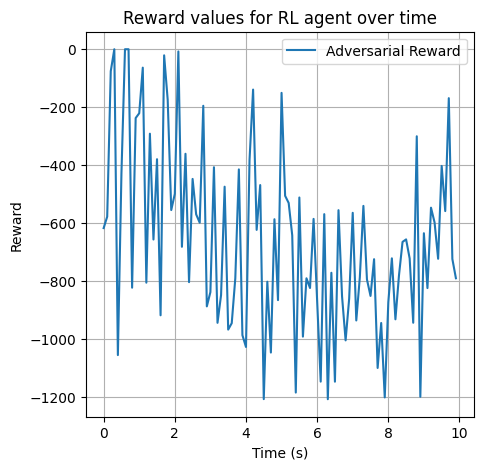

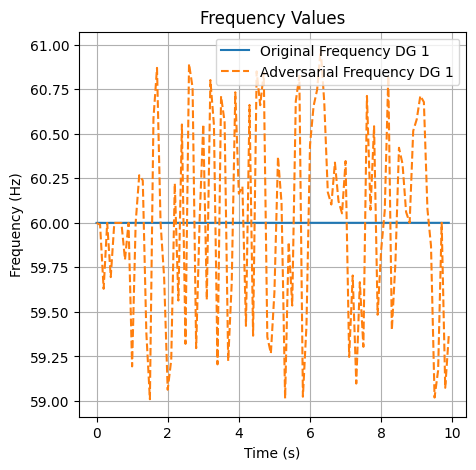

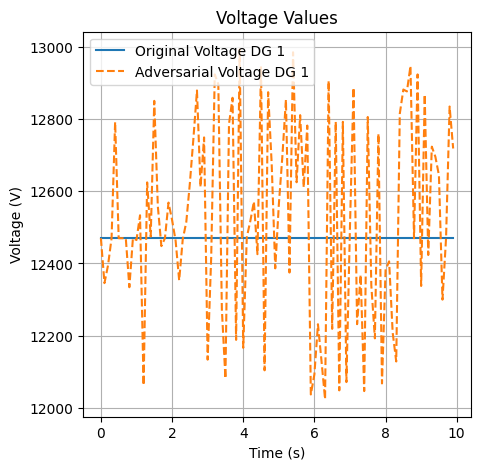

Average Deviation: 657.0519314206434
Performance Degradation (RD): 657.0519314206435
FD=[0.47466141 0.45524983 0.45559352]
VD=[234.87957356 208.05312976 233.42848506]
AD=3
mean_FD:0.4618349235234576
mean_VD:225.45372946008374
System Stability Index (SSI): 255.9155643836072


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values = np.zeros((N_DG, len(t), 3))

# Function to identify rare values using standard deviation
def is_rare(value, mean, std_dev, threshold=0.5):
    return value < (mean - threshold * std_dev) or value > (mean + threshold * std_dev)

# Track the observed distribution of f and v values
observed_f_values = []
observed_v_values = []

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Track observed distribution
        observed_f_values.append(dg.f)
        observed_v_values.append(dg.V_mag[0])  # Assuming we're interested in the first phase for simplicity

        mean_f = np.mean(observed_f_values)
        std_f = np.std(observed_f_values)
        mean_v = np.mean(observed_v_values)
        std_v = np.std(observed_v_values)

        # Apply adversarial manipulation to rare values
        if is_rare(dg.f, mean_f, std_f) or is_rare(dg.V_mag[0], mean_v, std_v):
            # Introduce corrupted data for rare values
            # manipulated_f = dg.f * (1 + 0.01)  # Larger perturbation for rare values
            # manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05))
            manipulated_f = np.random.uniform(59, 61)
            # manipulated_v = dg.V_mag * (1 + 0.05)
            # manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05))
            manipulated_v = np.random.uniform(12000, 13000, size = dg.V_mag.shape)
        else:
            manipulated_f = dg.f
            manipulated_v = dg.V_mag

        # Record manipulated values
        manipulated_f_values[dg.index, i] = manipulated_f
        manipulated_v_values[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    # Poison the agent's memory with manipulated states for rare values
    if any([is_rare(original_f_values[dg.index, i], mean_f, std_f) or is_rare(original_v_values[dg.index, i][0], mean_v, std_v) for dg in DGs]):
        rare_state = state.copy()
        for j in range(N_DG):
            if is_rare(original_f_values[j, i], mean_f, std_f):
                rare_state[j*5] = manipulated_f_values[j, i]  # Rare frequency value
            if is_rare(original_v_values[j, i][0], mean_v, std_v):
                rare_state[j*5+1:j*5+4] = manipulated_v_values[j, i]  # Rare voltage values
        agent.remember(rare_state, action, -manipulated_reward, next_state, done)
        recorded_states.append(rare_state)  # Record the state after the attack
    else:
        agent.remember(state, action, total_reward, next_state, done)

    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plotting the rewards
plt.figure(figsize=(5, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history, label='Adversarial Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
# plt.xlim(2, 10)
# plt.ylim(-2, -1.9)
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.show()

# Plotting the frequency values
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, original_f_values[i], label=f'Original Frequency DG {i+1}')
    plt.plot(t, manipulated_f_values[i], '--', label=f'Adversarial Frequency DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Plotting the voltage values
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, original_v_values[i, :, 0], label=f'Original Voltage DG {i+1}')
    plt.plot(t, manipulated_v_values[i, :, 0], '--', label=f'Adversarial Voltage DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
# Use ScalarFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Print recorded states after the attack
# print("Recorded States After the Attack:")
# for state in recorded_states:
#     print(state)

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")

# Replay Attack

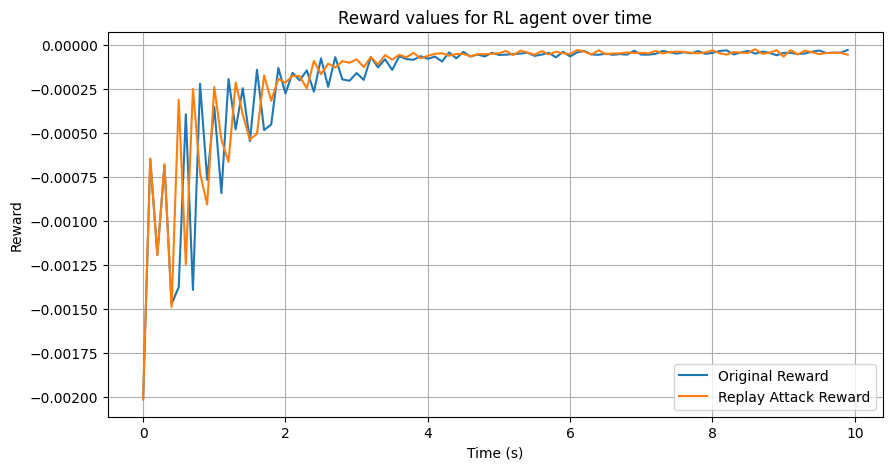

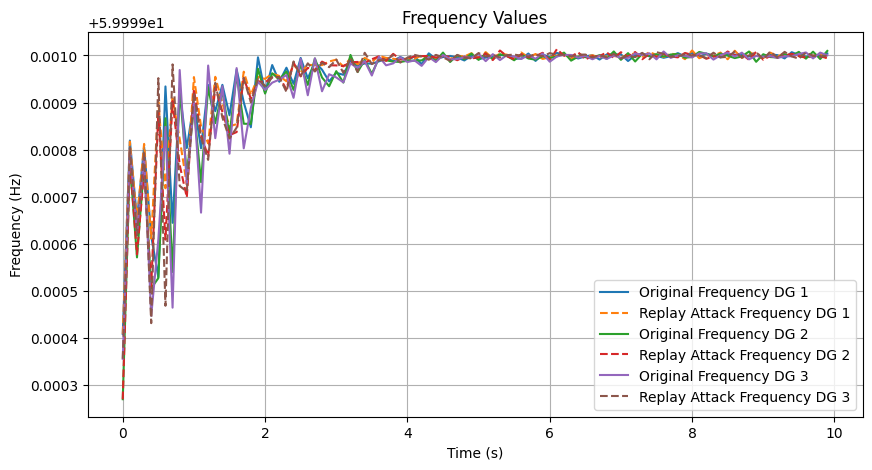

Average Deviation: 7.835376853215336e-05
Performance Degradation (RD): 1.643804517904355e-05
FD=[2.42999629 2.36997378 2.30996817]
VD=[505.03499066 492.56499116 480.09499174]
AD=0
System Stability Index (SSI): 494.9349706021907


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

def run_simulation(replay_attack=False, replay_start_time=2.0):
    t_sim = 10
    dt = 0.1

    t = np.arange(0, t_sim, dt)
    P_loads_history = []
    Q_loads_history = []
    P_loads_history_one = []
    Q_loads_history_one = []
    f_history = np.zeros((N_DG, len(t)))
    V_history = np.zeros((N_DG, len(t), 3))
    V_peak_history = np.zeros((N_DG, len(t)))
    delta_f_history = np.zeros((N_DG, len(t)))
    delta_v_history = np.zeros((N_DG, len(t), 3))
    delta_v_peak_history = np.zeros((N_DG, len(t)))
    P_max_history = np.zeros((N_DG, len(t)))
    loading_ratio_history = np.zeros((N_DG, len(t)))
    # frequency_error_history = [[] for _ in range(N_DG)]
    # voltage_error_history = [[] for _ in range(N_DG)]
    # f_nadir_history = np.zeros((N_DG, len(t)))
    # phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

    # Initialize DGs
    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        # Distribute the excess load among backup generators
        excess_load = total_P_loads - total_active_capacity
        for i in range(N_BACKUP_DG):
            shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

    replay_buffer = []

    reward_history = np.zeros(len(t))

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    stop_manipulation = [False] * N_DG

    # Simulation loop
    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        P_loads_history.append(P_loads)
        P_loads_history_one.append([x[0] for x in P_loads])
        Q_loads_history.append(Q_loads)
        Q_loads_history_one.append([x[0] for x in Q_loads])

        # Calculate the total active power generated by active DGs
        total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
        if total_active_power < total_P_loads:
            # Calculate the required power from backup generators
            required_power_from_backup = total_P_loads - total_active_power
            backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
            for i in range(N_DG, N_DG + N_BACKUP_DG):
                P_loads[i] = np.full(3, backup_power_per_dg)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        if replay_attack and t_step >= replay_start_time:
            # Replay attack: use captured state-action pairs
            if replay_buffer:
                state, action, reward, next_state, done = random.choice(replay_buffer)
                agent.remember(state, action, reward, next_state, done)
        else:
            # Normal operation: the agent decides the action
            action = agent.act(state)
            if t_step < replay_start_time:
                replay_buffer.append((state, action, reward_history[i-1] if i > 0 else 0, state, False))

        reconstruct = bool(action)  # boolean for action

        total_reward = 0

        for dg in DGs:

            delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
            delta_f_history[dg.index, i] = delta_freq
            delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

            dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            shared_data[dg.index]['f'] = dg.f
            shared_data[dg.index]['V_mag'] = dg.V_mag
            shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            shared_data[dg.index]['P_load'] = P_loads[dg.index]
            f_history[dg.index, i] = dg.f
            V_history[dg.index, i] = dg.V_mag
            P_max_history[dg.index, i] = dg.P_max
            loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
            delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

        reward_history[i] = total_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        done = t_step == t[-1]

        agent.remember(state, action, total_reward, next_state, done)
        agent.replay()

        for j, dg in enumerate(DGs):
            V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

    return reward_history, f_history, V_history, t

# Running the simulation without replay attack
reward_history, f_history, V_history, t = run_simulation(replay_attack=False)

# Running the simulation with replay attack
reward_history_replay, f_history_replay, V_history_replay, t_replay = run_simulation(replay_attack=True)

# Plotting the rewards in the same figure
plt.figure(figsize=(10, 5))
plt.plot(t, reward_history, label='Original Reward')
plt.plot(t_replay, reward_history_replay, label='Replay Attack Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.show()

# Plotting the frequency values in the same figure
plt.figure(figsize=(10, 5))
for i in range(N_DG):
    plt.plot(t, f_history[i], label=f'Original Frequency DG {i+1}')
    plt.plot(t_replay, f_history_replay[i], '--', label=f'Replay Attack Frequency DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.show()

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - reward_history_replay))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(reward_history_replay))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(f_history_replay, V_history_replay, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"System Stability Index (SSI): {SSI}")

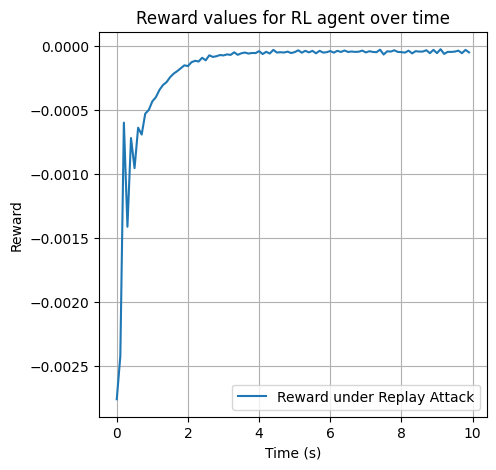

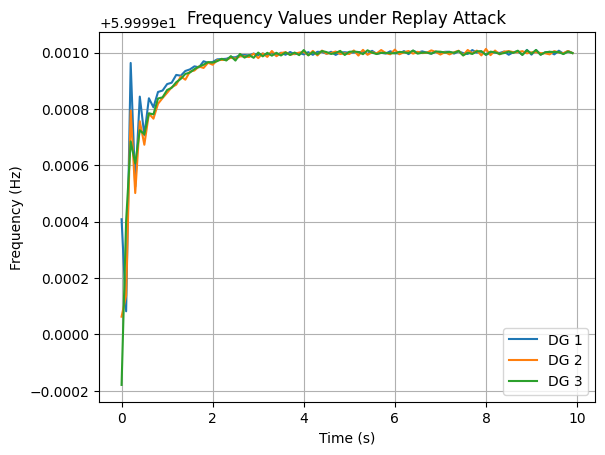

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1
replay_start_time = 0.4  # Replay attack start time in seconds

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_state = None
recorded_action = None
recorded_shared_data = None
reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    if t_step < replay_start_time:
        # Record the state, action, and resulting shared data before the replay attack starts
        action = agent.act(state)
        recorded_state = state.copy()
        recorded_action = action
        recorded_shared_data = shared_data.copy()
    else:
        # Use the recorded state, action, and shared data during the replay attack
        state = recorded_state
        action = recorded_action
        shared_data = recorded_shared_data

    reconstruct = bool(action)  # boolean for action

    total_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    if t_step < replay_start_time:
        agent.remember(state, action, total_reward, next_state, done)
        agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plot results
plt.figure(figsize=(5, 5))
plt.plot(t, reward_history, label='Reward under Replay Attack')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values under Replay Attack')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.grid()


# Replay attack on DRL agent


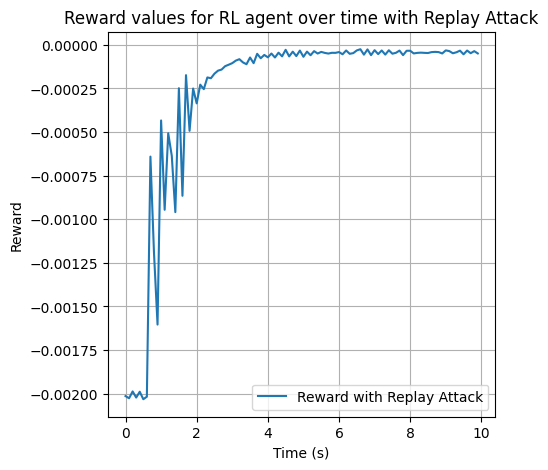

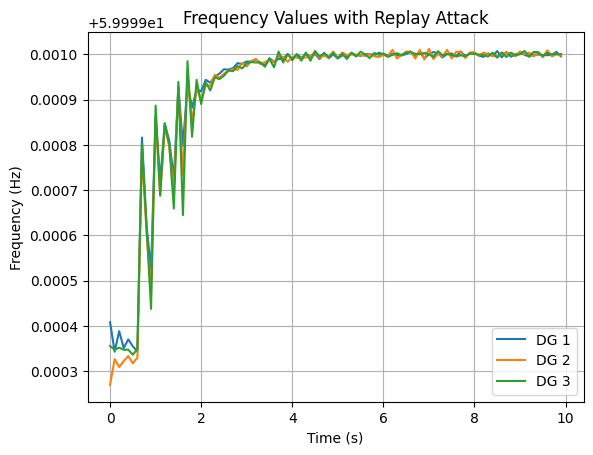

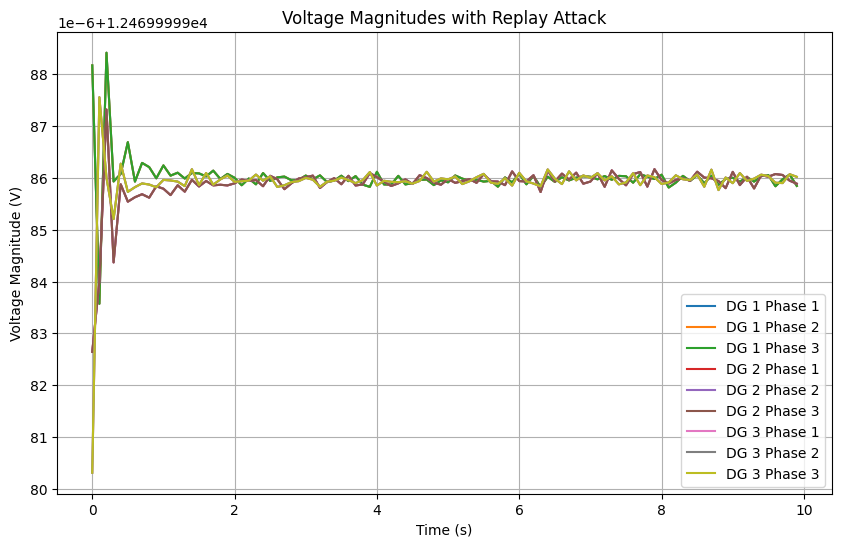

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1
# Initialize lists to store load values for each DG
P_loads_history = [[] for _ in range(N_DG)]
Q_loads_history = [[] for _ in range(N_DG)]
t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag, dtype=float)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG, dtype=float)

recorded_states = []

reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

# Replay attack parameters
replay_start_time = 1.5  # Time in seconds when the replay attack starts
replay_duration = 8  # Duration of the replay attack in seconds
is_replaying = False
replay_data = []

# Step to record states and actions for replay
record_start_time = 1
record_duration = 1.5

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # for j in range(N_DG):
    #     P_loads_history[j].append(P_loads[j][0])  # Store the first phase load as a representative
    #     Q_loads_history[j].append(Q_loads[j][0]) # Store the first phase load as a representative

    # Check for replay attack condition
    if replay_start_time <= t_step:
        is_replaying = True
    else:
        is_replaying = False

    # Check for record condition
    if record_start_time <= t_step < record_start_time + record_duration:
        record_data = True
    else:
        record_data = False

    # Simulate replay attack by using previously recorded states and actions
    if is_replaying and replay_data:
        current_shared_data = replay_data[i % len(replay_data)]['shared_data']
        action = replay_data[i % len(replay_data)]['action']
    else:
        current_shared_data = shared_data
        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])
        action = agent.act(state)

    reconstruct = bool(action)  # boolean for action

    total_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(current_shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), current_shared_data[dg.index]['P_load'], current_shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        current_shared_data[dg.index]['f'] = dg.f
        current_shared_data[dg.index]['V_mag'] = dg.V_mag
        current_shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        current_shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    if record_data:
        replay_data.append({'shared_data': current_shared_data.copy(), 'action': action})

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

plt.figure(figsize=(5, 5))
plt.plot(t, reward_history, label='Reward with Replay Attack')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time with Replay Attack')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values with Replay Attack')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.grid()

plt.figure(figsize=(10, 6))
for i in range(N_DG):
    for j in range(3):
        plt.plot(t, V_history[i][:, j], label=f'DG {i + 1} Phase {j + 1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Magnitude (V)')
plt.title('Voltage Magnitudes with Replay Attack')
plt.legend()
plt.grid()
plt.show()
P_loads_history = np.array(P_loads_history)
Q_loads_history = np.array(Q_loads_history)

# plt.figure(figsize=(10, 6))
# for i in range(N_DG):
#     plt.plot(t, P_loads_history[i], label=f'DG {i + 1}')
# plt.xlabel('Time (s)')
# plt.ylabel('Active Power Load (kW)')
# plt.title('Active Power Load (P_load) Over Time')
# plt.legend()
# plt.grid()
# plt.show()
# # Plot Q_load
# plt.figure(figsize=(10, 6))
# for i in range(N_DG):
#     plt.plot(t, Q_loads_history[i], label=f'DG {i + 1}')
# plt.xlabel('Time (s)')
# plt.ylabel('Reactive Power Load (kVar)')
# plt.title('Reactive Power Load (Q_load) Over Time')
# plt.legend()
# plt.grid()
# plt.show()

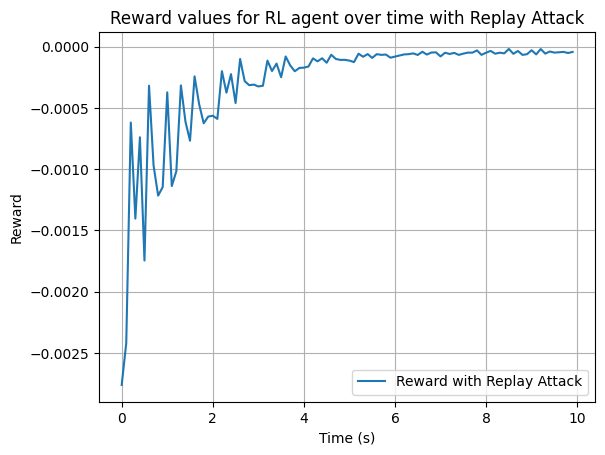

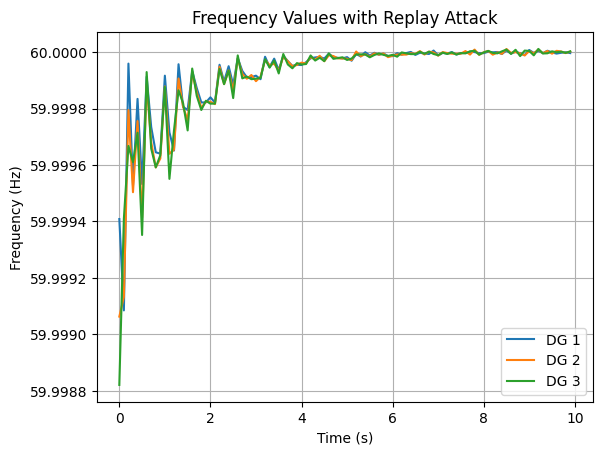

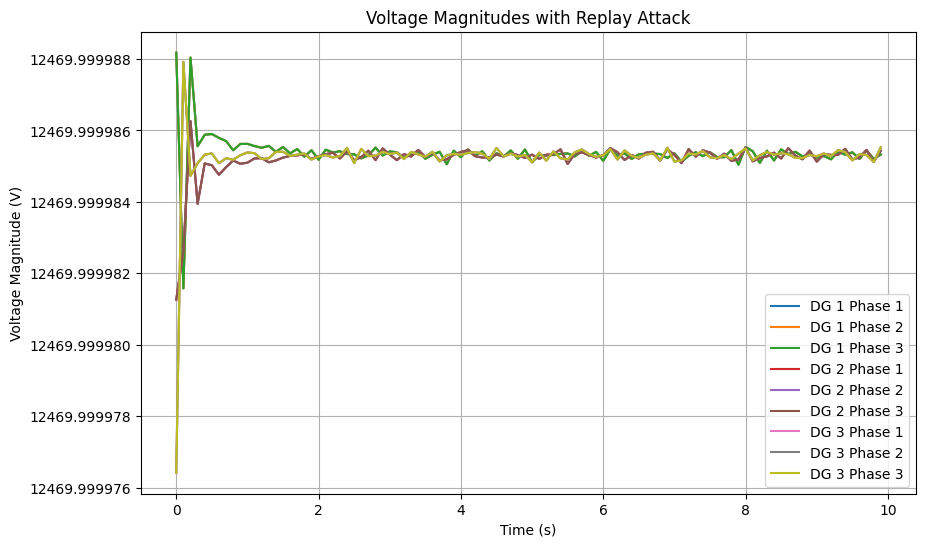

Average Deviation: 0.00028850938294247894
Performance Degradation (RD): 0.00028850938294247894
FD=[7.33893066e-05 8.60186158e-05 8.81270029e-05]
VD=[1.46221334e-05 1.47931351e-05 1.47648217e-05]
AD=0
mean_FD:8.251164178453507e-05
mean_VD:1.4726696729970473e-05
System Stability Index (SSI): 9.723833851450555e-05


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag, dtype=float)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG, dtype=float)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

# Replay attack parameters
replay_start_time =1.5  # Time in seconds when the replay attack starts
replay_duration = 8.5  # Duration of the replay attack in seconds
is_replaying = False
replay_data = []

# Record parameters
record_start_time = 0  # Time in seconds when to start recording
record_duration = 1  # Duration of the recording in seconds
record_data = False

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Check for replay attack condition
    # if replay_start_time <= t_step < replay_start_time + replay_duration:
    if replay_start_time <= t_step:
        is_replaying = True
    else:
        is_replaying = False

    # Check for record condition
    if record_start_time <= t_step < record_start_time + record_duration:
        record_data = True
    else:
        record_data = False

    # Simulate replay attack by using previously recorded states and actions
    if is_replaying and replay_data:
        current_shared_data = replay_data[i % len(replay_data)]['shared_data']
        action = replay_data[i % len(replay_data)]['action']
    else:
        current_shared_data = shared_data
        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])
        action = agent.act(state)

    reconstruct = bool(action)  # boolean for action

    total_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(current_shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), current_shared_data[dg.index]['P_load'], current_shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        current_shared_data[dg.index]['f'] = dg.f
        current_shared_data[dg.index]['V_mag'] = dg.V_mag
        current_shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        current_shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    if record_data:
        replay_data.append({'shared_data': current_shared_data.copy(), 'action': action})

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# plt.figure(figsize=(5, 5))
plt.plot(t, reward_history, label='Reward with Replay Attack')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time with Replay Attack')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values with Replay Attack')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.figure(figsize=(10, 6))
for i in range(N_DG):
    for j in range(3):
        plt.plot(t, V_history[i][:, j], label=f'DG {i + 1} Phase {j + 1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Magnitude (V)')
plt.title('Voltage Magnitudes with Replay Attack')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Define functions for FD, VD, AD, and SSI calculations
def calculate_FD(f_values, f_ref):
    return np.mean(np.abs(f_values - f_ref), axis=1)

def calculate_VD(v_values, v_nom_mag):
    return np.mean(np.abs(v_values - v_nom_mag), axis=(1, 2))

def calculate_AD(f_values, v_values, f_ref, v_nom_mag, epsilon_f, epsilon_v):
    return np.sum(np.abs(f_values - f_ref) > epsilon_f) + np.sum(np.abs(v_values - v_nom_mag) > epsilon_v)

# Define constants for SSI calculation
alpha = 1.0
beta = 1.0
gamma = 1.0
epsilon_f = 0.01
epsilon_v = 0.01

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(f_history, f_ref)
VD = calculate_VD(V_history, V_nom_mag)
AD = calculate_AD(f_history, V_history, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")


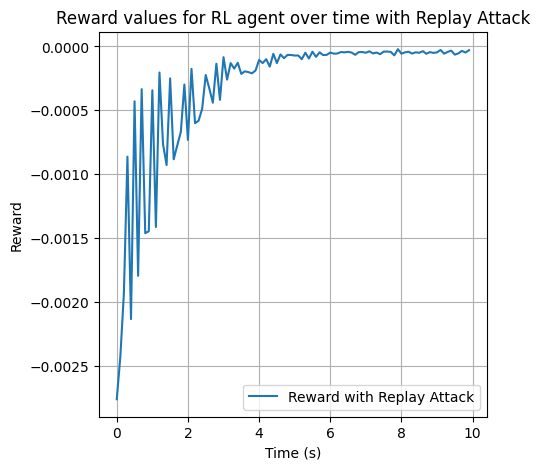

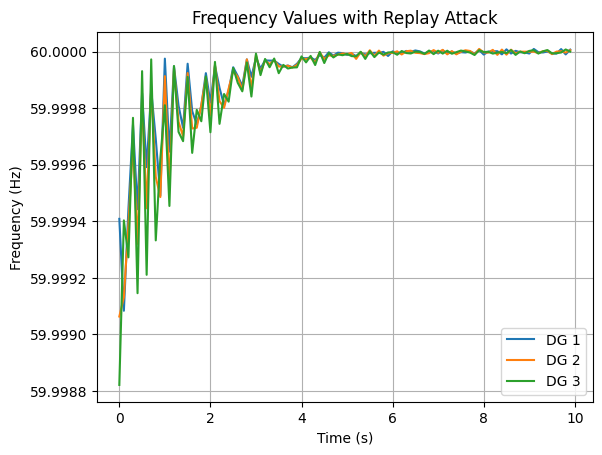

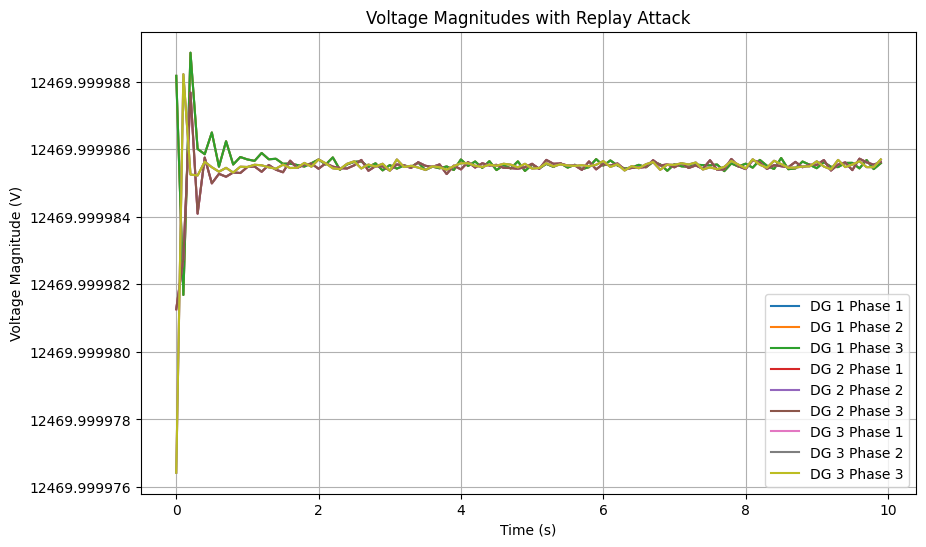

Average Deviation: 0.0003157221715525793
Performance Degradation (RD): 0.0003157221715525793
FD=[7.93445660e-05 9.43588862e-05 1.02708510e-04]
VD=[1.44167339e-05 1.45649626e-05 1.45560185e-05]
AD=0
mean_FD:9.213732087109368e-05
mean_VD:1.4512571675974565e-05
System Stability Index (SSI): 0.00010664989254706825


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag, dtype=float)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG, dtype=float)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

# Replay attack parameters
replay_start_time =4  # Time in seconds when the replay attack starts
replay_duration = 8.5  # Duration of the replay attack in seconds
is_replaying = False
replay_data = []

# Record parameters
record_start_time = 0  # Time in seconds when to start recording
record_duration = 0.5 # Duration of the recording in seconds
record_data = False

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Check for replay attack condition
    if replay_start_time <= t_step < replay_start_time + replay_duration:
        is_replaying = True
    else:
        is_replaying = False

    # Check for record condition
    if record_start_time <= t_step < record_start_time + record_duration:
        record_data = True
    else:
        record_data = False

    # Simulate replay attack by using previously recorded states and actions
    if is_replaying and replay_data:
        # current_shared_data = replay_data[i % len(replay_data)]['shared_data']
        current_shared_data = replay_data[np.random.randint(len(replay_data))]['shared_data']
        # action = replay_data[i % len(replay_data)]['action']
        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])
        action = agent.act(state)
    else:
        current_shared_data = shared_data
        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])
        action = agent.act(state)

    reconstruct = bool(action)  # boolean for action

    total_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(current_shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), current_shared_data[dg.index]['P_load'], current_shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        current_shared_data[dg.index]['f'] = dg.f
        current_shared_data[dg.index]['V_mag'] = dg.V_mag
        current_shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        current_shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    if record_data:
        replay_data.append({'shared_data': current_shared_data.copy(), 'action': action})

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

plt.figure(figsize=(5, 5))
plt.plot(t, reward_history, label='Reward with Replay Attack')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time with Replay Attack')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values with Replay Attack')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.figure(figsize=(10, 6))
for i in range(N_DG):
    for j in range(3):
        plt.plot(t, V_history[i][:, j], label=f'DG {i + 1} Phase {j + 1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Magnitude (V)')
plt.title('Voltage Magnitudes with Replay Attack')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Define functions for FD, VD, AD, and SSI calculations
def calculate_FD(f_values, f_ref):
    return np.mean(np.abs(f_values - f_ref), axis=1)

def calculate_VD(v_values, v_nom_mag):
    return np.mean(np.abs(v_values - v_nom_mag), axis=(1, 2))

def calculate_AD(f_values, v_values, f_ref, v_nom_mag, epsilon_f, epsilon_v):
    return np.sum(np.abs(f_values - f_ref) > epsilon_f) + np.sum(np.abs(v_values - v_nom_mag) > epsilon_v)

# Define constants for SSI calculation
alpha = 1.0
beta = 1.0
gamma = 1.0
epsilon_f = 0.01
epsilon_v = 0.01

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(f_history, f_ref)
VD = calculate_VD(V_history, V_nom_mag)
AD = calculate_AD(f_history, V_history, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")


# Spoofing Attack
Changing model parameters

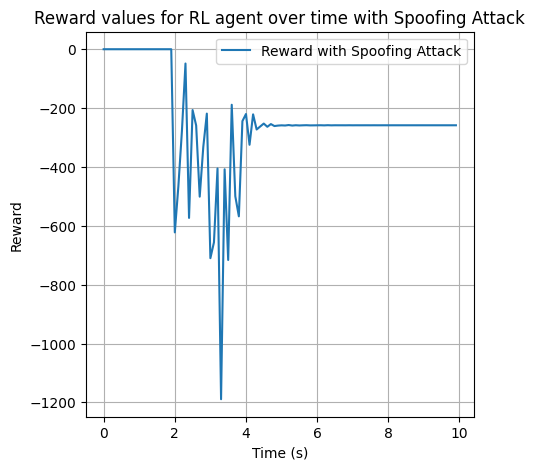

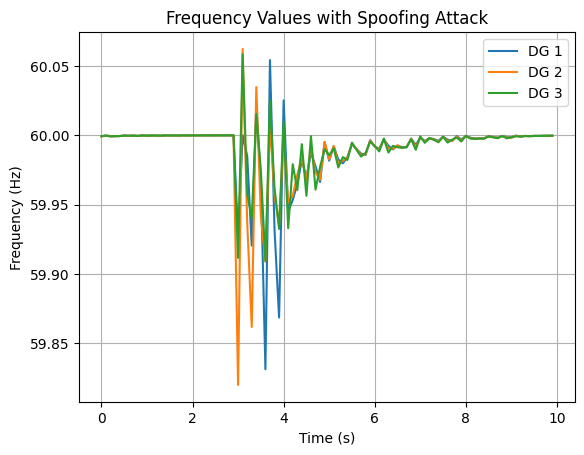

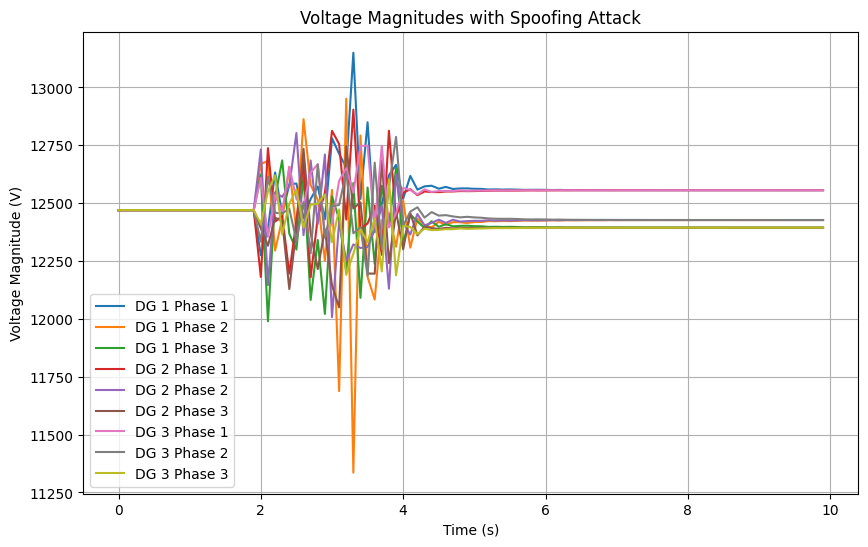

Performance Degradation (RD): 246.07976984053846
FD=[0.0117771  0.01244105 0.01039742]
VD=[83.38549196 76.19213263 64.18929761]
AD=1
mean_FD:0.011538524851643169
mean_VD:74.58897406957759
System Stability Index (SSI): 104.60051259442923


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])


# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag, dtype=float)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG, dtype=float)

recorded_states = []

reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

# Spoofing attack parameters
attack_start_time = 2  # Time in seconds when the attack starts
attack_duration = 2  # Duration of the attack in seconds
is_spoofing = False

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Check for spoofing attack condition
    if attack_start_time <= t_step < attack_start_time + attack_duration:
        is_spoofing = True
    else:
        is_spoofing = False

    # Simulate spoofing attack by altering shared data
    if is_spoofing:
        spoofed_data = shared_data.copy()
        for data in spoofed_data:
            data['f'] += np.random.uniform(-0.5, 0.5)  # Randomly alter frequency
            data['V_mag'] += np.random.uniform(-600, 600, 3)  # Randomly alter voltage magnitude
        current_shared_data = spoofed_data
    else:
        current_shared_data = shared_data

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg, dtype=float)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0

    for dg in DGs:

        delta_freq, delta_v = dg.secondary_control(current_shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), current_shared_data[dg.index]['P_load'], current_shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        current_shared_data[dg.index]['f'] = dg.f
        current_shared_data[dg.index]['V_mag'] = dg.V_mag
        current_shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        current_shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))


plt.figure(figsize=(5, 5))
plt.plot(t, reward_history, label='Reward with Spoofing Attack')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time with Spoofing Attack')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values with Spoofing Attack')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.grid()

plt.figure(figsize=(10, 6))
for i in range(N_DG):
    for j in range(3):
        plt.plot(t, V_history[i][:, j], label=f'DG {i + 1} Phase {j + 1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Magnitude (V)')
plt.title('Voltage Magnitudes with Spoofing Attack')
plt.legend()
plt.grid()
plt.show()

# Calculate average deviation between manipulated and actual reward history
average_deviation = (np.abs(actual_reward_history - reward_history))
# print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.mean(np.abs((actual_reward_history) -(reward_history)))
print(f"Performance Degradation (RD): {performance_degradation}")
# Calculate System Stability Index (SSI) components
def calculate_FD(f_values, f_ref):
    return np.mean(np.abs(f_values - f_ref), axis=1)

def calculate_VD(v_values, V_nom_mag):
    return np.mean(np.abs(v_values - V_nom_mag), axis=(1, 2))

# def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
#     count_affected_dgs = 0
#     for i in range(N_DG):
#         if np.max(np.abs(f_values[i] - f_ref)) > epsilon_f or np.max(np.abs(v_values[i] - V_nom_mag)) > epsilon_v:
#             count_affected_dgs += 1
#     return count_affected_dgs
def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
    count_affected_dgs = 0
    for i in range(N_DG):
        if (np.abs(np.mean(f_values[i]) - f_ref)) > epsilon_f or (np.abs(np.mean(v_values[i]) - V_nom_mag)) > epsilon_v:
            count_affected_dgs += 1
    return count_affected_dgs
# Calculate SSI components
FD = calculate_FD(f_history, f_ref)
VD = calculate_VD(V_history, V_nom_mag)
AD = calculate_AD(f_history, V_history, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
AD = 3
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f'mean_FD:{np.mean(FD)}')
print(f'mean_VD:{np.mean(VD)}')
print(f"System Stability Index (SSI): {SSI}")

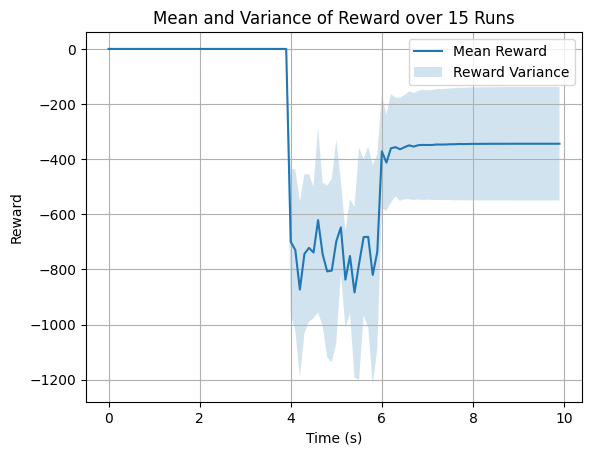

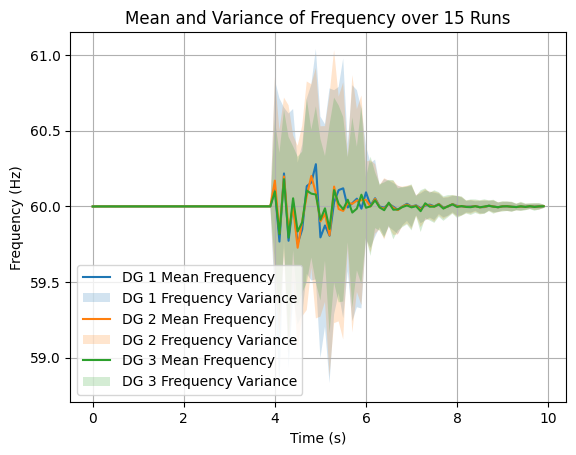

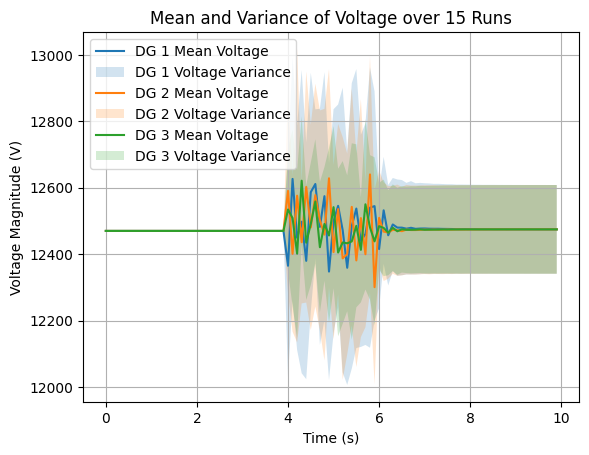

Average Deviation: [3.98460617e-04 7.04785377e-04 1.10210414e-04 7.14023100e-04
 4.64426345e-04 9.95195878e-04 3.89075645e-04 1.94528098e-04
 8.49943770e-05 1.50451520e-04 1.17900671e-04 3.98476498e-04
 1.58357427e-04 3.14878852e-04 1.74300911e-04 5.90721230e-05
 3.16936367e-04 2.44812202e-04 3.86327563e-04 1.78605614e-04
 2.17578629e-04 4.84693682e-05 2.00800249e-04 8.08296264e-05
 8.93768697e-05 6.48785345e-05 9.70364616e-05 5.76776354e-05
 7.29572420e-05 1.15960999e-04 5.72697963e-07 2.36485288e-05
 9.41732759e-05 1.62098984e-05 2.02311308e-05 8.84232888e-05
 3.78074936e-05 2.94147148e-06 5.97981898e-05 4.11421946e-05
 6.99886964e+02 7.29117622e+02 8.72586430e+02 7.43541740e+02
 7.21461842e+02 7.38242929e+02 6.21010273e+02 7.44944407e+02
 8.06887833e+02 8.04036421e+02 6.97338948e+02 6.47111649e+02
 8.36648997e+02 7.51047548e+02 8.83209316e+02 7.78835870e+02
 6.82412570e+02 6.81595201e+02 8.19700791e+02 7.35493642e+02
 3.71389037e+02 4.12219096e+02 3.60341695e+02 3.56182979e+02
 3.63

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag, dtype=float)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3, dtype=float)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1
num_runs = 15

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []

reward_histories = []
f_histories = []
V_histories = []

for run in range(num_runs):
    f_history = np.zeros((N_DG, len(t)))
    V_history = np.zeros((N_DG, len(t), 3))
    reward_history = np.zeros(len(t))

    # Initialize DGs
    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag, dtype=float)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        # Distribute the excess load among backup generators
        excess_load = total_P_loads - total_active_capacity
        for backup_dg_num in range(N_BACKUP_DG):
            shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG, dtype=float)

    recorded_states = []

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    stop_manipulation = [False] * N_DG

    # Spoofing attack parameters
    attack_start_time = 4  # Time in seconds when the attack starts
    attack_duration = 2  # Duration of the attack in seconds
    is_spoofing = False

    # Simulation loop
    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
        P_loads_history.append(P_loads)
        P_loads_history_one.append([x[0] for x in P_loads])
        Q_loads_history.append(Q_loads)
        Q_loads_history_one.append([x[0] for x in Q_loads])

        # Check for spoofing attack condition
        if attack_start_time <= t_step < attack_start_time + attack_duration:
            is_spoofing = True
        else:
            is_spoofing = False

        # Simulate spoofing attack by altering shared data
        if is_spoofing:
            spoofed_data = shared_data.copy()
            for data in spoofed_data:
                data['f'] += np.random.uniform(-3, 3)  # Randomly alter frequency
                data['V_mag'] += np.random.uniform(-750, 750, 3)  # Randomly alter voltage magnitude
            current_shared_data = spoofed_data
        else:
            current_shared_data = shared_data

        # Calculate the total active power generated by active DGs
        total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
        if total_active_power < total_P_loads:
            # Calculate the required power from backup generators
            required_power_from_backup = total_P_loads - total_active_power
            backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
            for i in range(N_DG, N_DG + N_BACKUP_DG):
                P_loads[i] = np.full(3, backup_power_per_dg, dtype=float)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        # Centralized DQN agent decides the control mode for all DGs
        action = agent.act(state)
        reconstruct = bool(action) # boolean for action

        total_reward = 0

        for dg in DGs:

            delta_freq, delta_v = dg.secondary_control(current_shared_data, Kp, Ki, reconstruct=reconstruct)
            dg.primary_control((m_p, m_q), current_shared_data[dg.index]['P_load'], current_shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            current_shared_data[dg.index]['f'] = dg.f
            current_shared_data[dg.index]['V_mag'] = dg.V_mag
            current_shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            current_shared_data[dg.index]['P_load'] = P_loads[dg.index]
            f_history[dg.index, i] = dg.f
            V_history[dg.index, i] = dg.V_mag

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

        reward_history[i] = total_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        done = t_step == t[-1]

        agent.remember(state, action, total_reward, next_state, done)
        agent.replay()

    reward_histories.append(reward_history)
    f_histories.append(f_history)
    V_histories.append(V_history)

# Convert to numpy arrays for easier manipulation
reward_histories = np.array(reward_histories)
f_histories = np.array(f_histories)
V_histories = np.array(V_histories)

# Calculate mean and variance
mean_reward = np.mean(reward_histories, axis=0)
var_reward = np.var(reward_histories, axis=0)

mean_f = np.mean(f_histories, axis=0)
var_f = np.var(f_histories, axis=0)

mean_V = np.mean(V_histories, axis=0)
var_V = np.var(V_histories, axis=0)

# Plotting results
# plt.figure(figsize=(10, 6))
plt.plot(t, mean_reward, label='Mean Reward')
plt.fill_between(t, mean_reward - np.sqrt(var_reward), mean_reward + np.sqrt(var_reward), alpha=0.2, label='Reward Variance')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Mean and Variance of Reward over 15 Runs')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(10, 6))
for i in range(N_DG):
    plt.plot(t, mean_f[i], label=f'DG {i + 1} Mean Frequency')
    plt.fill_between(t, mean_f[i] - np.sqrt(var_f[i]), mean_f[i] + np.sqrt(var_f[i]), alpha=0.2, label=f'DG {i + 1} Frequency Variance')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean and Variance of Frequency over 15 Runs')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(10, 6))
for i in range(N_DG):
    for j in range(1):
        plt.plot(t, mean_V[i][:, j], label=f'DG {i + 1} Mean Voltage')
        plt.fill_between(t, mean_V[i][:, j] - np.sqrt(var_V[i][:, j]), mean_V[i][:, j] + np.sqrt(var_V[i][:, j]), alpha=0.2, label=f'DG {i + 1} Voltage Variance')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Magnitude (V)')
plt.title('Mean and Variance of Voltage over 15 Runs')
plt.legend()
plt.grid()
plt.show()
# Calculate average deviation between manipulated and actual reward history
average_deviation = (np.abs(actual_reward_history - mean_reward))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.mean(np.abs((actual_reward_history) -(mean_reward)))
print(f"Performance Degradation (RD): {performance_degradation}")
# Calculate System Stability Index (SSI) components
def calculate_FD(f_values, f_ref):
    return np.mean(np.abs(f_values - f_ref), axis=1)

def calculate_VD(v_values, V_nom_mag):
    return np.mean(np.abs(v_values - V_nom_mag), axis=(1, 2))

# def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
#     count_affected_dgs = 0
#     for i in range(N_DG):
#         if np.max(np.abs(f_values[i] - f_ref)) > epsilon_f or np.max(np.abs(v_values[i] - V_nom_mag)) > epsilon_v:
#             count_affected_dgs += 1
#     return count_affected_dgs
def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
    count_affected_dgs = 0
    for i in range(N_DG):
        if (np.abs(np.mean(f_values[i]) - f_ref)) > epsilon_f or (np.abs(np.mean(v_values[i]) - V_nom_mag)) > epsilon_v:
            count_affected_dgs += 1
    return count_affected_dgs
# Calculate SSI components
FD = calculate_FD(f_histories, f_ref)
VD = calculate_VD(V_histories, V_nom_mag)
AD = calculate_AD(mean_f, mean_V, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
AD = 3
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f'mean_FD:{np.mean(FD)}')
print(f'mean_VD:{np.mean(VD)}')
print(f"System Stability Index (SSI): {SSI}")

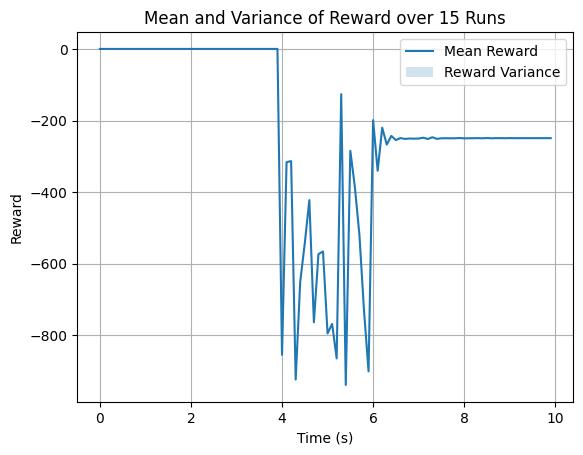

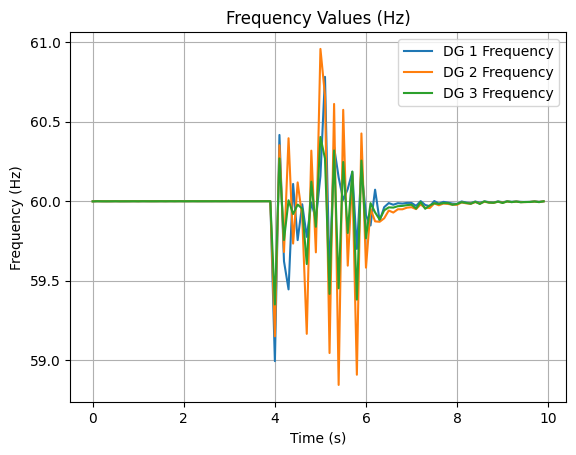

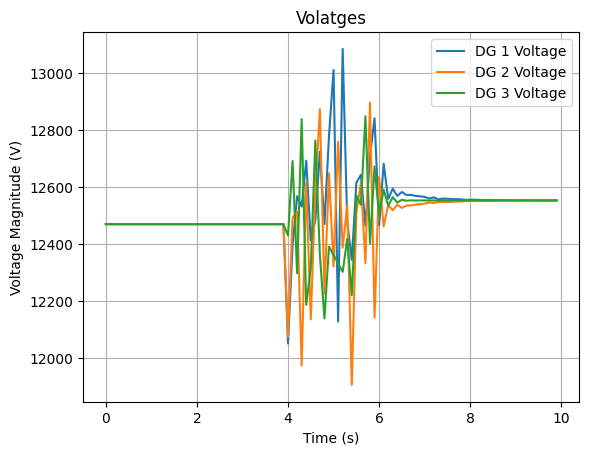

In [ ]:
# Plotting results
# plt.figure(figsize=(10, 6))
plt.plot(t, mean_reward, label='Mean Reward')
plt.fill_between(t, mean_reward - np.sqrt(var_reward), mean_reward + np.sqrt(var_reward), alpha=0.2, label='Reward Variance')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Mean and Variance of Reward over 15 Runs')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(10, 6))
for i in range(N_DG):
    plt.plot(t, mean_f[i], label=f'DG {i + 1} Frequency')
    # plt.fill_between(t, mean_f[i] - np.sqrt(var_f[i]), mean_f[i] + np.sqrt(var_f[i]), alpha=0.2, label=f'DG {i + 1} Frequency Variance')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
# plt.title('Mean and Variance of Frequency over 15 Runs')
plt.title('Frequency Values (Hz)')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(10, 6))
for i in range(N_DG):
    for j in range(1):
        # plt.plot(t, mean_V[i][:, j], label=f'DG {i + 1} Mean Voltage')
        plt.plot(t, mean_V[i][:, j], label=f'DG {i + 1} Voltage')
        # plt.fill_between(t, mean_V[i][:, j] - np.sqrt(var_V[i][:, j]), mean_V[i][:, j] + np.sqrt(var_V[i][:, j]), alpha=0.2, label=f'DG {i + 1} Voltage Variance')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Magnitude (V)')
plt.title('Volatges')
# plt.title('Mean and Variance of Voltage over 15 Runs')
plt.legend()
plt.grid()
plt.show()

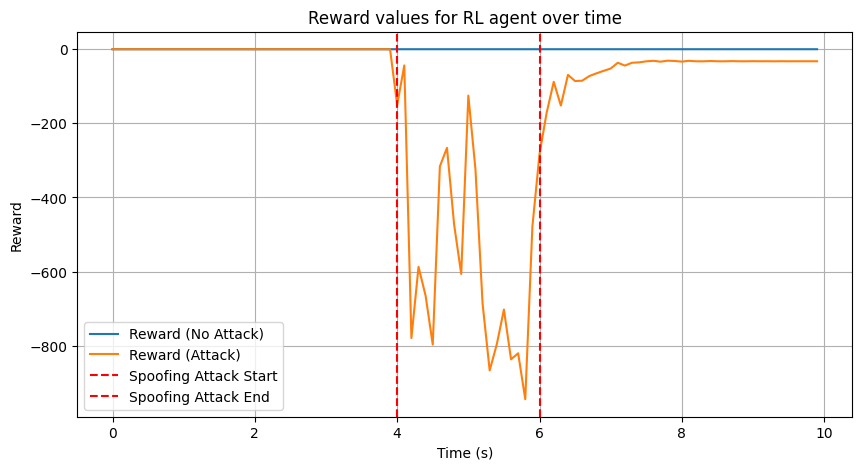

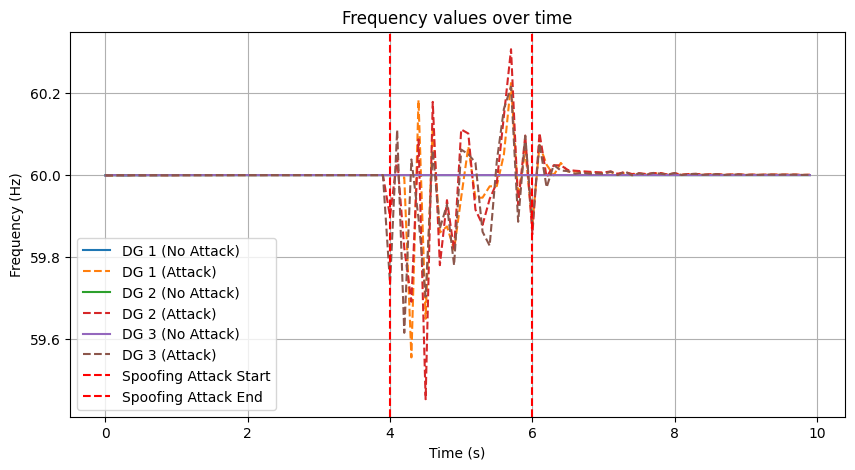

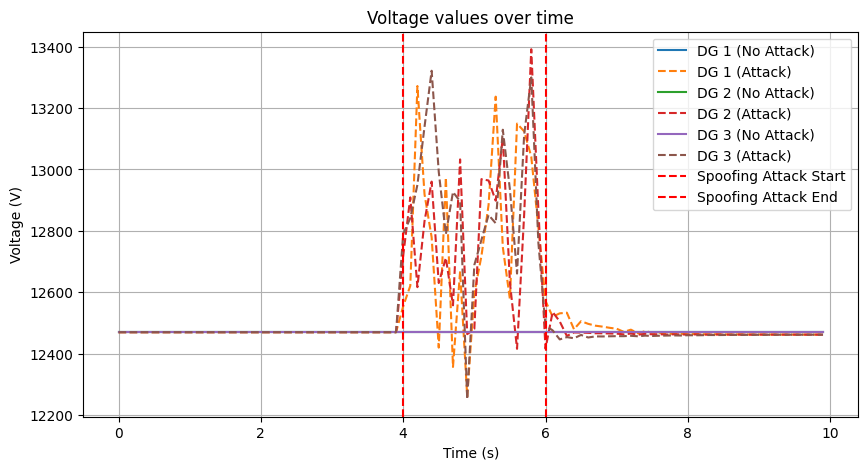

Average Deviation: 134.13960031328747
Performance Degradation (RD): 134.13948606800275


AxisError: axis 2 is out of bounds for array of dimension 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

# Simulation parameters
t_sim = 10
dt = 0.1
attack_duration = 2
attack_start_time = 4

def simulate(attack=False):
    t = np.arange(0, t_sim, dt)
    P_loads_history = []
    Q_loads_history = []
    P_loads_history_one = []
    Q_loads_history_one = []
    f_history = np.zeros((N_DG, len(t)))
    V_history = np.zeros((N_DG, len(t), 3))
    V_peak_history = np.zeros((N_DG, len(t)))
    delta_f_history = np.zeros((N_DG, len(t)))
    delta_v_history = np.zeros((N_DG, len(t), 3))
    delta_v_peak_history = np.zeros((N_DG, len(t)))
    P_max_history = np.zeros((N_DG, len(t)))
    loading_ratio_history = np.zeros((N_DG, len(t)))
    frequency_error_history = [[] for _ in range(N_DG)]
    voltage_error_history = [[] for _ in range(N_DG)]
    f_nadir_history = np.zeros((N_DG, len(t)))
    phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

    # Initialize DGs
    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        # Distribute the excess load among backup generators
        excess_load = total_P_loads - total_active_capacity
        for backup_dg_num in range(N_BACKUP_DG):
            shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

    recorded_states = []

    reward_history = np.zeros(len(t))

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    stop_manipulation = [False] * N_DG

    # Simulation loop
    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        P_loads_history.append(P_loads)
        P_loads_history_one.append([x[0] for x in P_loads])
        Q_loads_history.append(Q_loads)
        Q_loads_history_one.append([x[0] for x in Q_loads])

        # Calculate the total active power generated by active DGs
        total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
        if total_active_power < total_P_loads:
            # Calculate the required power from backup generators
            required_power_from_backup = total_P_loads - total_active_power
            backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
            for i in range(N_DG, N_DG + N_BACKUP_DG):
                P_loads[i] = np.full(3, backup_power_per_dg)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        # Centralized DQN agent decides the control mode for all DGs
        action = agent.act(state)
        reconstruct = bool(action) # boolean for action

        total_reward = 0

        for dg in DGs:

            delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
            delta_f_history[dg.index, i] = delta_freq
            delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

            dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            shared_data[dg.index]['f'] = dg.f
            shared_data[dg.index]['V_mag'] = dg.V_mag
            shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            shared_data[dg.index]['P_load'] = P_loads[dg.index]
            f_history[dg.index, i] = dg.f
            V_history[dg.index, i] = dg.V_mag
            P_max_history[dg.index, i] = dg.P_max
            loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
            delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

            # Introduce spoofing attack
            if attack and attack_start_time <= t_step < attack_start_time + attack_duration:
                shared_data[dg.index]['f'] += np.random.uniform(-0.5, 0.5)  # Manipulate frequency
                shared_data[dg.index]['V_mag'] += np.random.uniform(-500, 500, 3)  # Manipulate voltage

        reward_history[i] = total_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        done = t_step == t[-1]

        agent.remember(state, action, total_reward, next_state, done)
        agent.replay()

        for j, dg in enumerate(DGs):
            V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

    return t, reward_history, f_history, V_peak_history

# Run simulations
t, reward_history_no_attack, f_history_no_attack, V_peak_history_no_attack = simulate(attack=False)
t, reward_history_attack, f_history_attack, V_peak_history_attack = simulate(attack=True)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, reward_history_no_attack, label='Reward (No Attack)')
plt.plot(t, reward_history_attack, label='Reward (Attack)')
plt.axvline(x=attack_start_time, color='r', linestyle='--', label='Spoofing Attack Start')
plt.axvline(x=attack_start_time + attack_duration, color='r', linestyle='--', label='Spoofing Attack End')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(N_DG):
    plt.plot(t, f_history_no_attack[i], label=f'DG {i+1} (No Attack)')
    plt.plot(t, f_history_attack[i], linestyle='--', label=f'DG {i+1} (Attack)')
plt.axvline(x=attack_start_time, color='r', linestyle='--', label='Spoofing Attack Start')
plt.axvline(x=attack_start_time + attack_duration, color='r', linestyle='--', label='Spoofing Attack End')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency values over time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
for i in range(N_DG):
    plt.plot(t, V_peak_history_no_attack[i], label=f'DG {i+1} (No Attack)')
    plt.plot(t, V_peak_history_attack[i], linestyle='--', label=f'DG {i+1} (Attack)')
plt.axvline(x=attack_start_time, color='r', linestyle='--', label='Spoofing Attack Start')
plt.axvline(x=attack_start_time + attack_duration, color='r', linestyle='--', label='Spoofing Attack End')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage values over time')
plt.legend()
plt.grid()
plt.show()

# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history_no_attack - reward_history_attack))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history_no_attack) - np.mean(reward_history_attack))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(f_history_attack, f_ref)
VD = calculate_VD(V_peak_history_attack, V_nom_mag)
AD = calculate_AD(f_history_attack, V_peak_history_attack, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"System Stability Index (SSI): {SSI}")

# Attack on inference time

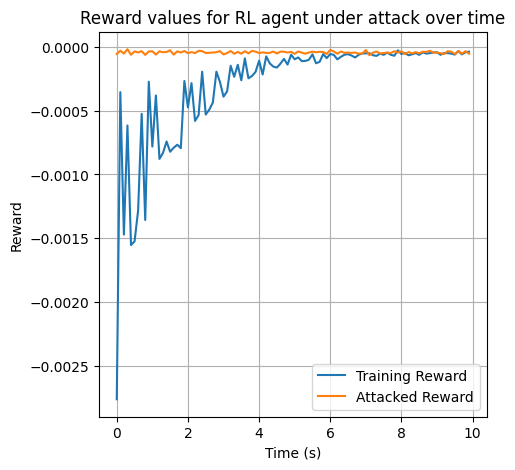

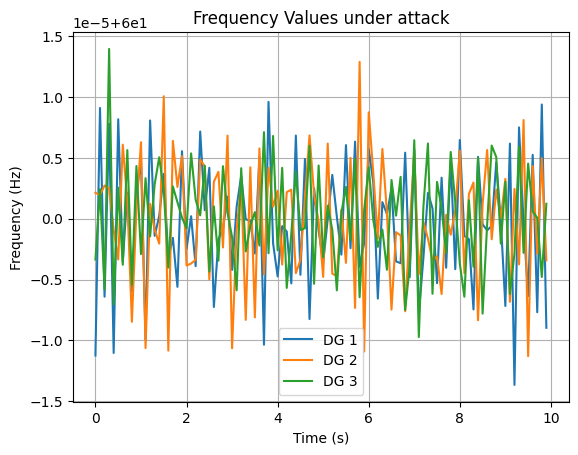

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

# Function to simulate attack by perturbing the state
def apply_attack(state):
    noise = np.random.normal(0, 0.1, len(state))  # Adjust noise level as needed
    attacked_state = state + noise
    return attacked_state

# Training loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0

    for dg in DGs:

        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Reset for inference
reward_history_inference = np.zeros(len(t))

# Inference loop with attack
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Apply the attack to the state during inference
    attacked_state = apply_attack(state)

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(attacked_state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0

    for dg in DGs:

        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    reward_history_inference[i] = total_reward

# Plotting
plt.figure(figsize=(5, 5))
plt.plot(t, reward_history, label='Training Reward')
plt.plot(t, reward_history_inference, label='Attacked Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent under attack over time')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values under attack')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.grid()


# Random Action Attack
- In this attack we randomly alter the agent's action with acertain probability.

In [ ]:
class DQNAgent:
    ...
    def act(self, state, attack=False, attack_probability=0.1):
        if attack and np.random.rand() < attack_probability:
            return random.randrange(self.action_dim)  # Random action
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()
    ...


# Observation Spoofing attack
- In this attack, we tamper with the observation fed to the agent.

In [ ]:
def spoof_observations(state, spoof_probability=0.1):
    spoofed_state = state.copy()
    for i in range(len(state)):
        if np.random.rand() < spoof_probability:
            spoofed_state[i] += np.random.normal(0, 0.1)  # Adding noise to the state
    return spoofed_state

# Reward Manipulation Attack
- Alther the reward received by the agent.

In [ ]:
def manipulate_reward(reward, manipulation_probability=0.1):
    if np.random.rand() < manipulation_probability:
        return reward * np.random.uniform(0.5, 1.5)  # Randomly alter the reward
    return reward


In [ ]:
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, attack=False, attack_probability=0.1):
        if attack and np.random.rand() < attack_probability:
            return random.randrange(self.action_dim)  # Random action
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)

# Function to run the simulation and return the results
def run_simulation(attack_type='none', attack_dgs=None):
    P_loads_history = []
    Q_loads_history = []
    f_history = np.zeros((N_DG, len(t)))
    V_history = np.zeros((N_DG, len(t), 3))
    delta_f_history = np.zeros((N_DG, len(t)))
    delta_v_history = np.zeros((N_DG, len(t), 3))
    reward_history = np.zeros(len(t))

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag, dtype=float)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        excess_load = total_P_loads - total_active_capacity
        for backup_dg_num in range(N_BACKUP_DG):
            shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG, dtype=float)

    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
        P_loads_history.append(P_loads)
        Q_loads_history.append(Q_loads)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(False)])

        action = agent.act(state)
        reconstruct = bool(action)

        total_reward = 0

        for dg in DGs:
            if attack_type == 'poisoning' and attack_dgs and dg.index in attack_dgs:
                delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
                dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq * 1.05, delta_v * 1.05)
            elif attack_type == 'backdoor' and i > len(t) / 2:
                delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
                dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq * 1.1, delta_v * 1.1)
            elif attack_type == 'spoofing' and i > len(t) / 2:
                shared_data[dg.index]['f'] += np.random.uniform(-0.5, 0.5)
                shared_data[dg.index]['V_mag'] += np.random.uniform(-100, 100, 3)
                delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
                dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)
            else:
                delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
                dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            shared_data[dg.index]['f'] = dg.f
            shared_data[dg.index]['V_mag'] = dg.V_mag
            shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            shared_data[dg.index]['P_load'] = P_loads[dg.index]
            f_history[dg.index, i] = dg.f
            V_history[dg.index, i] = dg.V_mag
            delta_f_history[dg.index, i] = delta_freq
            delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

        reward_history[i] = total_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(False)])

        done = t_step == t[-1]

        agent.remember(state, action, total_reward, next_state, done)
        agent.replay()

    return reward_history, f_history, V_history, t

# Define the attack scenarios
attack_scenarios = {
    'Normal': {'attack_type': 'none', 'attack_dgs': None},
    'Poisoning 1 DG': {'attack_type': 'poisoning', 'attack_dgs': [0]},
    'Poisoning 2 DGs': {'attack_type': 'poisoning', 'attack_dgs': [0, 1]},
    'Poisoning All DGs': {'attack_type': 'poisoning', 'attack_dgs': [0, 1, 2]},
    'Backdoor': {'attack_type': 'backdoor', 'attack_dgs': None},
    'Spoofing': {'attack_type': 'spoofing', 'attack_dgs': None}
}

# Function to calculate the performance degradation
def calculate_performance_degradation(reward_history_before, reward_history_after):
    T = len(reward_history_before)
    RD = np.abs(np.sum(reward_history_before - reward_history_after) / T)
    return RD

# Function to calculate the system stability index
def calculate_system_stability_index(f_history, V_history, alpha=1.0, beta=1.0, gamma=10.0, epsilon_f=0.5, epsilon_v=100):
    T = f_history.shape[1]
    FD = np.mean(np.abs(f_history - f_ref))
    VD = np.mean(np.abs(V_history - V_nom_mag))
    AD = np.sum(np.max(np.abs(f_history - f_ref), axis=1) > epsilon_f) + np.sum(np.max(np.abs(V_history - V_nom_mag), axis=1) > epsilon_v)
    SSI = alpha * FD + beta * VD + gamma * AD
    return SSI

# Run simulations and calculate metrics for each scenario
results = {}
for scenario, params in attack_scenarios.items():
    reward_history, f_history, V_history, t = run_simulation(**params)
    if scenario == 'Normal':
        reward_history_normal = reward_history
    RD = calculate_performance_degradation(reward_history_normal, reward_history)
    SSI = calculate_system_stability_index(f_history, V_history)
    results[scenario] = {'RD': RD, 'SSI': SSI}

# Print the results
for scenario, metrics in results.items():
    print(f"{scenario}: RD = {metrics['RD']}, SSI = {metrics['SSI']}")


Normal: RD = 0.0, SSI = 9.299754883952479e-05
Poisoning 1 DG: RD = 1.0475320034899483e-05, SSI = 9.006825001748098e-05
Poisoning 2 DGs: RD = 3.616888501326798e-05, SSI = 0.00010562831664517584
Poisoning All DGs: RD = 2.2497384107111885e-05, SSI = 0.00010061486043613381
Backdoor: RD = 8.783860037866021e-05, SSI = 0.00012811690097647006
Spoofing: RD = 47.94696849411528, SSI = 77.21869814500393


Enchanting attack

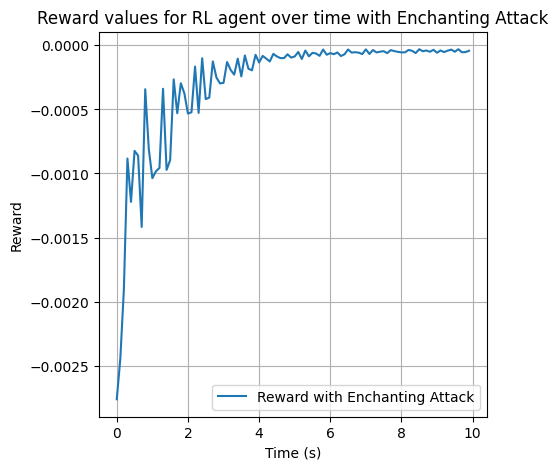

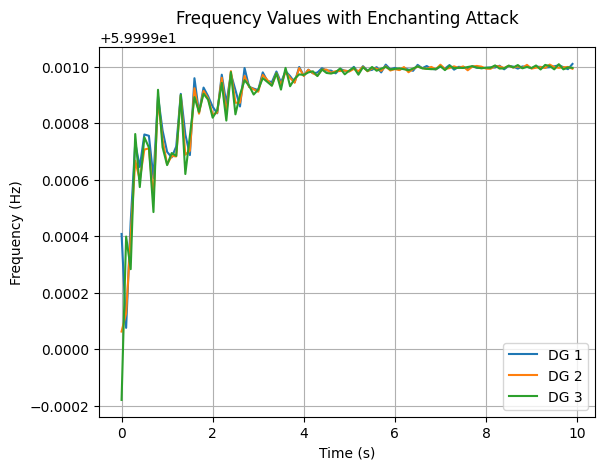

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

# Define the target state for the enchanting attack
target_freq = 70  # Target frequency for attack
target_voltage = 15000  # Target voltage magnitude for attack

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

class EnchantingAttack:
    def __init__(self, target_freq, target_voltage):
        self.target_freq = target_freq
        self.target_voltage = target_voltage

    def plan_sequence(self, current_state, steps):
        # Plan a sequence of actions to reach the target state
        planned_actions = []
        # Placeholder for a simple planning heuristic (to be replaced with actual planning logic)
        for _ in range(steps):
            planned_actions.append(random.randint(0, 1))  # Randomly choose an action (0 or 1)
        return planned_actions

    def apply(self, state, planned_action):
        # Manipulate the state to misguide the agent to take the planned action
        manipulated_state = state.copy()
        manipulated_state[0] = self.target_freq  # Manipulate frequency
        manipulated_state[1:4] = [self.target_voltage] * 3  # Manipulate voltage magnitudes
        return manipulated_state

t_sim = 10
dt = 0.1
t = np.arange(0, t_sim, dt)

# Initialize histories
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []
reward_history = np.zeros(len(t))
state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)
stop_manipulation = [False] * N_DG

# Initialize the enchanting attack
attack = EnchantingAttack(target_freq, target_voltage)
initial_state = [f_ref] + [V_nom_mag] * 3 + [0]  # Initial state assuming no manipulation and initial voltage as V_nom_mag
planned_actions = attack.plan_sequence(initial_state, len(t))  # Placeholder for initial state and steps

# Simulation loop with enchanting attack
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Apply enchanting attack to manipulate the state
    manipulated_state = attack.apply(state, planned_actions[i])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(manipulated_state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(manipulated_state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plotting the results
plt.figure(figsize=(5, 5))
plt.plot(t, reward_history, label='Reward with Enchanting Attack')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time with Enchanting Attack')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values with Enchanting Attack')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.grid()
